### Интеллектуальные системы и технологии  
Практика №1. Поиск ассоциативных правил вручную и с помощью алгоритмов на языке python  
Жаров Всеволод, ИММО-01-23

In [3]:
import pandas as pd
import numpy as np

from apriori_python import apriori
from efficient_apriori import apriori as eff_apriori
from fpgrowth_py import fpgrowth
import time
import matplotlib.pyplot as plt
from PyARMViz import PyARMViz

import warnings
warnings.filterwarnings("ignore")

### Работа с собственным набором данных вручную, алгоритм Apriori  

#### Выявление частых предментных наборов

Создадим вручную собственный набор данных по 5 варианту "Сформировать набор из 20 транзакций на основе продуктов, 
употребляемых на завтрак, обед и ужин."

In [2]:
row_data = pd.read_excel("./data/row_data.xlsx", header=None, na_filter=False)
row_data

0        1        2        3        4        5        6    7
0   колбаса   хлопья     хлеб      чай                                
1      яйца     хлеб  булочка  котлеты                                
2       сок  печенье  колбаса                                         
3       чай  сандвич  печенье  булочка                                
4       чай     хлеб  печенье                                         
5   котлеты     яйца  колбаса      чай  булочка                       
6       сок      чай     хлеб  колбаса                                
7   колбаса   хлопья      чай                                         
8       сок      чай                                                  
9   котлеты     яйца  колбаса     хлеб  печенье                       
10     хлеб      чай  сандвич   хлопья                                
11  котлеты  сандвич  печенье      чай     хлеб  булочка  колбаса  сок
12      сок     хлеб  булочка     яйца  колбаса                       
13  печенье  колбаса                                                  
14      сок   хлопья     хлеб  булочка                                
15  колбаса   хлопья  печенье     яйца                                
16  котлеты   хлопья     яйца     хлеб      сок  булочка  колбаса  чай
17      чай  печенье                                                  
18  булочка  печенье  колбаса   хлопья                                
19  сандвич  колбаса  печенье   хлопья      сок     хлеб

Также представим эти данные в нормализированном виде

In [3]:
norm_data = pd.read_excel("./data/norm_data.xlsx")
norm_data

Колбаса  Хлопья  Хлеб  Чай  Яйца  Булочка  Котлеты  Сандвич  Печенье  Сок
0         1       0     1    1     0        0        0        0        0    0
1         0       0     1    0     1        1        1        0        0    0
2         1       0     0    0     0        0        0        0        1    1
3         0       0     0    1     0        1        0        1        1    0
4         0       0     1    1     0        0        0        0        1    0
5         1       0     0    1     1        1        1        0        0    0
6         1       0     1    1     0        0        0        0        0    1
7         1       1     0    1     0        0        0        0        0    0
8         0       0     0    1     0        0        0        0        0    1
9         1       0     1    0     1        0        1        0        1    0
10        0       1     1    1     0        0        0        1        0    0
11        1       0     1    1     0        1        1        1        1    1
12        1       0     1    0     1        1        0        0        0    1
13        1       0     0    0     0        0        0        0        1    0
14        0       1     1    0     0        1        0        0        0    1
15        1       1     0    0     1        0        0        0        1    0
16        1       1     1    1     1        1        1        0        0    1
17        0       0     0    1     0        0        0        0        1    0
18        1       1     0    0     0        1        0        0        1    0
19        1       1     1    0     0        0        0        1        1    1

Просуммируем значения по столбцам, чтобы выяснить, какие из 10 товаров, встречающиеся в нашей искусственной выборке, будут частотными. Возьмём  пороговое значения __дельта = 5__. Все товары, что будут встречаться реже 5 раз, будут считаться нечастотными

In [4]:
DELTA = 5

In [5]:
norm_data.sum(axis=0)

Колбаса    13
Хлопья      7
Хлеб       11
Чай        11
Яйца        6
Булочка     8
Котлеты     5
Сандвич     4
Печенье    10
Сок         8
dtype: int64

Как видно из данной таблицы, практически все товары, кроме __Сандвича__, частотные. Их мы и будем использовать для дальнейшего построения цепочек из двух товаров

In [6]:
frequent_1 = np.array(norm_data.columns)
frequent_1 = np.setdiff1d(frequent_1, ["Сандвич"]) # Удаляем из частотной выборки из 1 элемента сандвич, т.к. его частнотность = 4 < 5
print(frequent_1)

['Булочка' 'Колбаса' 'Котлеты' 'Печенье' 'Сок' 'Хлеб' 'Хлопья' 'Чай'
 'Яйца']


Создадим функцию, чтобы подсчитать количество транзакций, в которых будут встречаться двойки товаров

In [7]:
def count_chains(data: pd.DataFrame, names, need_to_print_table = False):
    """
    Функция для подсчёта количества транзакций, в которых будут встречаться один или несколько указанных товаров\n
    data: данные, в которых ведётся подсчёт\n
    names: list of str, названия товаров для множественной проверки\n
    need_to_print_table: нужно ли выводить представление таблицы, в котором отражены строки 
        с указанными товарами. По умолчанию False\n
    -----
    return: количество транзакций с указанными товарами 
    """
    
    view = data[data[names[0]] == 1]
    if len(names) != 1:
        for i in range(1, len(names)):
            view = view[view[names[i]] == 1]

    if need_to_print_table:
        print(view)
    return view.shape[0]

In [8]:
print("Всего совпадений - ", count_chains(norm_data, ["Колбаса", "Хлопья"], need_to_print_table=True))

    Колбаса  Хлопья  Хлеб  Чай  Яйца  Булочка  Котлеты  Сандвич  Печенье  Сок
7         1       1     0    1     0        0        0        0        0    0
15        1       1     0    0     1        0        0        0        1    0
16        1       1     1    1     1        1        1        0        0    1
18        1       1     0    0     0        1        0        0        1    0
19        1       1     1    0     0        0        0        1        1    1
Всего совпадений -  5


Как видно, пара "Колбаса-Хлопья" пройдёт, ибо количество транзакций в нашей выборке = 5, что соответствует пороговому значению дельта  
Теперь проверим это для всех возможных двоек из одиночных частотных товаров

In [9]:
frequent_2 = np.empty([0,2], dtype=str)
all_2_chains = pd.DataFrame()

for i in range(len(frequent_1)-1):
    for j in range(i+1, len(frequent_1)):
        n1 = frequent_1[i]
        n2 = frequent_1[j]
        max_count = count_chains(norm_data, [n1, n2])
        
        all_2_chains = all_2_chains.append(pd.DataFrame([n1, n2, max_count]).T)

        if(max_count >= DELTA):
            frequent_2 = np.append(frequent_2, [[n1, n2]], 0)

all_2_chains.columns = ["name1", "name2", "max_count"]
all_2_chains.reset_index(drop=True, inplace=True)
all_2_chains


name1    name2 max_count
0   Булочка  Колбаса         5
1   Булочка  Котлеты         4
2   Булочка  Печенье         3
3   Булочка      Сок         4
4   Булочка     Хлеб         5
5   Булочка   Хлопья         3
6   Булочка      Чай         4
7   Булочка     Яйца         4
8   Колбаса  Котлеты         4
9   Колбаса  Печенье         7
10  Колбаса      Сок         6
11  Колбаса     Хлеб         7
12  Колбаса   Хлопья         5
13  Колбаса      Чай         6
14  Колбаса     Яйца         5
15  Котлеты  Печенье         2
16  Котлеты      Сок         2
17  Котлеты     Хлеб         4
18  Котлеты   Хлопья         1
19  Котлеты      Чай         3
20  Котлеты     Яйца         4
21  Печенье      Сок         3
22  Печенье     Хлеб         4
23  Печенье   Хлопья         3
24  Печенье      Чай         4
25  Печенье     Яйца         2
26      Сок     Хлеб         6
27      Сок   Хлопья         3
28      Сок      Чай         4
29      Сок     Яйца         2
30     Хлеб   Хлопья         4
31     Хлеб      Чай         6
32     Хлеб     Яйца         4
33   Хлопья      Чай         3
34   Хлопья     Яйца         2
35      Чай     Яйца         2

Выведем пары, что прошли порог в дельта= 5

In [10]:
all_2_chains[all_2_chains["max_count"] >= DELTA]

name1    name2 max_count
0   Булочка  Колбаса         5
4   Булочка     Хлеб         5
9   Колбаса  Печенье         7
10  Колбаса      Сок         6
11  Колбаса     Хлеб         7
12  Колбаса   Хлопья         5
13  Колбаса      Чай         6
14  Колбаса     Яйца         5
26      Сок     Хлеб         6
31     Хлеб      Чай         6

In [11]:
print(frequent_2)

[['Булочка' 'Колбаса']
 ['Булочка' 'Хлеб']
 ['Колбаса' 'Печенье']
 ['Колбаса' 'Сок']
 ['Колбаса' 'Хлеб']
 ['Колбаса' 'Хлопья']
 ['Колбаса' 'Чай']
 ['Колбаса' 'Яйца']
 ['Сок' 'Хлеб']
 ['Хлеб' 'Чай']]


Теперь создаём тройки кандидатов в частые наборы по следующему принципу:
- объединяем все двойки со всеми;
- удаляем дублирующие товары в рамках одного набора;
- удаляем те наборы, в которых не три элемента ( в данном случае те, в которых либо 2, либо 3 элемента)

In [13]:
frequent_3_candidate = np.empty([0,3])
for i in range(frequent_2.shape[0]-1):
    for j in range(i, frequent_2.shape[0]):
            temp = np.append(frequent_2[i], frequent_2[j])
            temp = np.unique(temp)
            if len(temp) == 3:
                frequent_3_candidate = np.append(frequent_3_candidate, [temp], 0)

frequent_3_candidate = np.unique(frequent_3_candidate, axis=0)
print(frequent_3_candidate)

[['Булочка' 'Колбаса' 'Печенье']
 ['Булочка' 'Колбаса' 'Сок']
 ['Булочка' 'Колбаса' 'Хлеб']
 ['Булочка' 'Колбаса' 'Хлопья']
 ['Булочка' 'Колбаса' 'Чай']
 ['Булочка' 'Колбаса' 'Яйца']
 ['Булочка' 'Сок' 'Хлеб']
 ['Булочка' 'Хлеб' 'Чай']
 ['Колбаса' 'Печенье' 'Сок']
 ['Колбаса' 'Печенье' 'Хлеб']
 ['Колбаса' 'Печенье' 'Хлопья']
 ['Колбаса' 'Печенье' 'Чай']
 ['Колбаса' 'Печенье' 'Яйца']
 ['Колбаса' 'Сок' 'Хлеб']
 ['Колбаса' 'Сок' 'Хлопья']
 ['Колбаса' 'Сок' 'Чай']
 ['Колбаса' 'Сок' 'Яйца']
 ['Колбаса' 'Хлеб' 'Хлопья']
 ['Колбаса' 'Хлеб' 'Чай']
 ['Колбаса' 'Хлеб' 'Яйца']
 ['Колбаса' 'Хлопья' 'Чай']
 ['Колбаса' 'Хлопья' 'Яйца']
 ['Колбаса' 'Чай' 'Яйца']
 ['Сок' 'Хлеб' 'Чай']]


Сократим такой большой список кандидатов с помощью свойства антимонотонности

In [15]:
def antimonotonicity(data: pd.DataFrame, names_3x, need_to_print=False):
    """
    Функция для проверки свойства антимонотонности для кандидатов в тройки частотных товаров\n
    data: данные, в которых ведётся подсчёт\n
    names_3x: набор из трёх товаров\n
    need_to_print: нужно ли выводить количество транзакций с наборами двоек из тройки. По умолчанию False\n
    -----
    return: True, если данный кандидат прошёл свойство антимонотонности,
            False, если не прошёл
    """
    count_for_2x = np.array(count_chains(data, [names_3x[0], names_3x[1]]))
    count_for_2x = np.append(count_for_2x, count_chains(data, [names_3x[0], names_3x[2]]))
    count_for_2x = np.append(count_for_2x, count_chains(data, [names_3x[1], names_3x[2]]))
    if need_to_print:
        print(f"{names_3x[0]}, {names_3x[1]} - {int(count_for_2x[0])}")
        print(f"{names_3x[0]}, {names_3x[2]} - {int(count_for_2x[1])}")
        print(f"{names_3x[1]}, {names_3x[2]} - {int(count_for_2x[2])}")
    
    return np.min(count_for_2x) >= DELTA

In [16]:
print(antimonotonicity(norm_data, frequent_3_candidate[2], need_to_print=True))

Булочка, Колбаса - 5
Булочка, Хлеб - 5
Колбаса, Хлеб - 7
True


В данном случае, тройка ["Булочка", "Колбаса", "Хлеб"] прошла свойство антимонотонности и может оставаться в наборе

In [17]:
print(antimonotonicity(norm_data, frequent_3_candidate[3], need_to_print=True))

Булочка, Колбаса - 5
Булочка, Хлопья - 3
Колбаса, Хлопья - 5
False


А вот тройка ["Колбаса", "Булочка", "Хлопья"] не прошла - двойка ["Булочка", "Хлопья"] имеется только в 3 транзакциях, что меньше установленной дельты = 5  

Теперь пройдёмся по всему набору и сократим те, которые не прошли это свойство

In [18]:
frequent_3_candidate_anti = np.empty([0,3], dtype=str)

for names3x in frequent_3_candidate:
    if antimonotonicity(norm_data, names3x):
        frequent_3_candidate_anti = np.append(frequent_3_candidate_anti, [names3x], 0)

print(frequent_3_candidate_anti)

[['Булочка' 'Колбаса' 'Хлеб']
 ['Колбаса' 'Сок' 'Хлеб']
 ['Колбаса' 'Хлеб' 'Чай']]


Проверим получившиеся тройки на частотность, чтобы удостоверится, что все они - частотные

In [19]:
frequent_3 = np.empty([0,3], dtype=str)
all_3_chains = pd.DataFrame()

for names3x in frequent_3_candidate_anti:
        max_count = count_chains(norm_data, names3x)
        
        all_3_chains = all_3_chains.append(pd.DataFrame([names3x[0], names3x[1], names3x[2], max_count]).T)

        if(max_count >= DELTA):
            frequent_3 = np.append(frequent_3, [names3x], 0)

all_3_chains.columns = ["name1", "name2", "name3", "max_count"]
all_3_chains.reset_index(drop=True, inplace=True)
all_3_chains

name1    name2 name3 max_count
0  Булочка  Колбаса  Хлеб         3
1  Колбаса      Сок  Хлеб         5
2  Колбаса     Хлеб   Чай         4

И те, что прошли порог в дельта = 5

In [20]:
all_3_chains[all_3_chains["max_count"] >= DELTA]

name1 name2 name3 max_count
1  Колбаса   Сок  Хлеб         5

И в частотные тройки войдёт только одна тройка - ['Колбаса' 'Сок' 'Хлеб']. Кандидатов в частотные четвёрки уже сделать не получится

In [21]:
print(frequent_1)
print("-----")
print(frequent_2)
print("-----")
print(frequent_3)

['Булочка' 'Колбаса' 'Котлеты' 'Печенье' 'Сок' 'Хлеб' 'Хлопья' 'Чай'
 'Яйца']
-----
[['Булочка' 'Колбаса']
 ['Булочка' 'Хлеб']
 ['Колбаса' 'Печенье']
 ['Колбаса' 'Сок']
 ['Колбаса' 'Хлеб']
 ['Колбаса' 'Хлопья']
 ['Колбаса' 'Чай']
 ['Колбаса' 'Яйца']
 ['Сок' 'Хлеб']
 ['Хлеб' 'Чай']]
-----
[['Колбаса' 'Сок' 'Хлеб']]


Таким образом, у нас получились следующие частотные для дельта = 5 наборы из одного, двух и трёх элементов. Они отражены блоком выше  

#### Генерация ассоциативных правил

In [22]:
def gen_all_to_all(data, frequent):
    """
    Функция для создания таблицы pd.DataFrame со сгенерированными ассоциативными правилами и их достоверностью и поддержкой\n
    data: данные, в которых ведётся подсчёт\n
    frequent: частотные двойки (!) или тройки (!)\n
    -----
    return: таблицу pd.DataFrame с пятью колонками: условие, следствие, поддержка, достоверность, S*C
    """
    N = data.shape[0]

    n_small = frequent.shape[0]
    n_small_num = frequent.shape[1]
    
    table_1 = np.empty([0, n_small_num - 1])
    table_2 = np.empty([0, 1])
    table_3 = np.empty([0, 1])
    table_4 = np.empty([0, 1])

    for i in range(n_small):
        temp = frequent[i]

        if n_small_num == 2:
            table_1 = np.append(table_1, temp[0])
            table_1 = np.append(table_1, temp[1])
        if n_small_num == 3:
            table_1 = np.append(table_1, [[temp[0], temp[1]]], 0)
            table_1 = np.append(table_1, [[temp[0], temp[2]]], 0)
            table_1 = np.append(table_1, [[temp[1], temp[2]]], 0)
        
        for h in range(n_small_num - 1, -1, -1):
            table_2 = np.append(table_2, temp[h])


    for j in range(len(table_1)):

        if n_small_num == 2:
            s = count_chains(data, [table_1[j], table_2[j]]) / N # поддержка
            c = (s * N) / count_chains(data, [table_1[j]]) # достоверность
        if n_small_num == 3:
            s = count_chains(data, [table_1[j][0], table_1[j][1], table_2[j]]) / N # поддержка
            c = (s * N) / count_chains(data, [table_1[j][0], table_1[j][1]]) # достоверность
        
        table_3 = np.append(table_3, np.array(s))
        table_4 = np.append(table_4, np.array(c))

    if n_small_num != 2:
        temp = np.empty([0, 1], str)
        for x in table_1:
            temp = np.append(temp, str(x[0] + ", " + x[1]))
        table_1 = temp

    output = pd.DataFrame({
        "Условие" : table_1,
        "Следствие" : table_2,
        "Поддержка" : table_3,
        "Достоверность" : table_4,
        "S * C": table_3 * table_4
    })


    return output

In [23]:
ass_2 = gen_all_to_all(norm_data, frequent_2)
ass_3 = gen_all_to_all(norm_data, frequent_3)
ass = ass_2.append(ass_3)
ass.reset_index(drop=True, inplace=True)
ass

Условие Следствие  Поддержка  Достоверность     S * C
0         Булочка   Колбаса       0.25       0.625000  0.156250
1         Колбаса   Булочка       0.25       0.384615  0.096154
2         Булочка      Хлеб       0.25       0.625000  0.156250
3            Хлеб   Булочка       0.25       0.454545  0.113636
4         Колбаса   Печенье       0.35       0.538462  0.188462
5         Печенье   Колбаса       0.35       0.700000  0.245000
6         Колбаса       Сок       0.30       0.461538  0.138462
7             Сок   Колбаса       0.30       0.750000  0.225000
8         Колбаса      Хлеб       0.35       0.538462  0.188462
9            Хлеб   Колбаса       0.35       0.636364  0.222727
10        Колбаса    Хлопья       0.25       0.384615  0.096154
11         Хлопья   Колбаса       0.25       0.714286  0.178571
12        Колбаса       Чай       0.30       0.461538  0.138462
13            Чай   Колбаса       0.30       0.545455  0.163636
14        Колбаса      Яйца       0.25       0.384615  0.096154
15           Яйца   Колбаса       0.25       0.833333  0.208333
16            Сок      Хлеб       0.30       0.750000  0.225000
17           Хлеб       Сок       0.30       0.545455  0.163636
18           Хлеб       Чай       0.30       0.545455  0.163636
19            Чай      Хлеб       0.30       0.545455  0.163636
20   Колбаса, Сок      Хлеб       0.25       0.833333  0.208333
21  Колбаса, Хлеб       Сок       0.25       0.714286  0.178571
22      Сок, Хлеб   Колбаса       0.25       0.833333  0.208333

Установим значение минимальное значение достоверности равным 70%, и посмотрим, какие ассоциативные правила останутся

In [24]:
MIN_C = 0.7

ass[ass["Достоверность"] > MIN_C]

Условие Следствие  Поддержка  Достоверность     S * C
7             Сок   Колбаса       0.30       0.750000  0.225000
11         Хлопья   Колбаса       0.25       0.714286  0.178571
15           Яйца   Колбаса       0.25       0.833333  0.208333
16            Сок      Хлеб       0.30       0.750000  0.225000
20   Колбаса, Сок      Хлеб       0.25       0.833333  0.208333
21  Колбаса, Хлеб       Сок       0.25       0.714286  0.178571
22      Сок, Хлеб   Колбаса       0.25       0.833333  0.208333

#### Лишнее

In [25]:
# all_names = np.array(norm_data.columns)
# N = all_names.shape[0]


# first_table = np.array([])
# second_table = np.array([])
# third_table = np.array([])
# fourth_table = np.array([])
# for i in range(N):
#     first_table = np.append(first_table, ((all_names[i] + " ") * (N - 1)).split(" ")[:-1])
#     second_table = np.append(second_table, np.setdiff1d(all_names, all_names[i]))

# for j in range(len(first_table)):
#     s = count_chains(norm_data, [first_table[j], second_table[j]]) / N # поддержка
#     c = (s * N) / count_chains(norm_data, [first_table[j]]) # достоверность
#     third_table = np.append(third_table, np.array(s))
#     fourth_table = np.append(fourth_table, np.array(c))


# associative = pd.DataFrame({"Условие" : first_table,
#                             "Следствие" : second_table,
#                             "Поддержка" : third_table,
#                             "Достоверность" : fourth_table})


# associative

### Работа с собственным набором данных, алгоритм FPGrowth

Посмотрим, какие товары чаще встречаются, чтобы потом отсортировать колонки в соответствии с этим  
Порог дельта по-прежнему возьмём равным 5

In [26]:
norm_data.sum(axis=0)

Колбаса    13
Хлопья      7
Хлеб       11
Чай        11
Яйца        6
Булочка     8
Котлеты     5
Сандвич     4
Печенье    10
Сок         8
dtype: int64

Отсортированные по колонкам данные по убыванию частоты (поддержки) встречи товаров в чеке (и без сандвича, т.к. порог дельта = 5 он не прошёл)

In [27]:
fp_data = pd.read_excel("./data/norm_data_fp.xlsx")
fp_data

Колбаса  Хлеб  Чай  Печенье  Сок  Булочка  Хлопья  Яйца  Котлеты
0         1     1    1        0    0        0       0     0        0
1         0     1    0        0    0        1       0     1        1
2         1     0    0        1    1        0       0     0        0
3         0     0    1        1    0        1       0     0        0
4         0     1    1        1    0        0       0     0        0
5         1     0    1        0    0        1       0     1        1
6         1     1    1        0    1        0       0     0        0
7         1     0    1        0    0        0       1     0        0
8         0     0    1        0    1        0       0     0        0
9         1     1    0        1    0        0       0     1        1
10        0     1    1        0    0        0       1     0        0
11        1     1    1        1    1        1       0     0        1
12        1     1    0        0    1        1       0     1        0
13        1     0    0        1    0        0       0     0        0
14        0     1    0        0    1        1       1     0        0
15        1     0    0        1    0        0       1     1        0
16        1     1    1        0    1        1       1     1        1
17        0     0    1        1    0        0       0     0        0
18        1     0    0        1    0        1       1     0        0
19        1     1    0        1    1        0       1     0        0

И теперь строим дерево (было построено в draw.io)

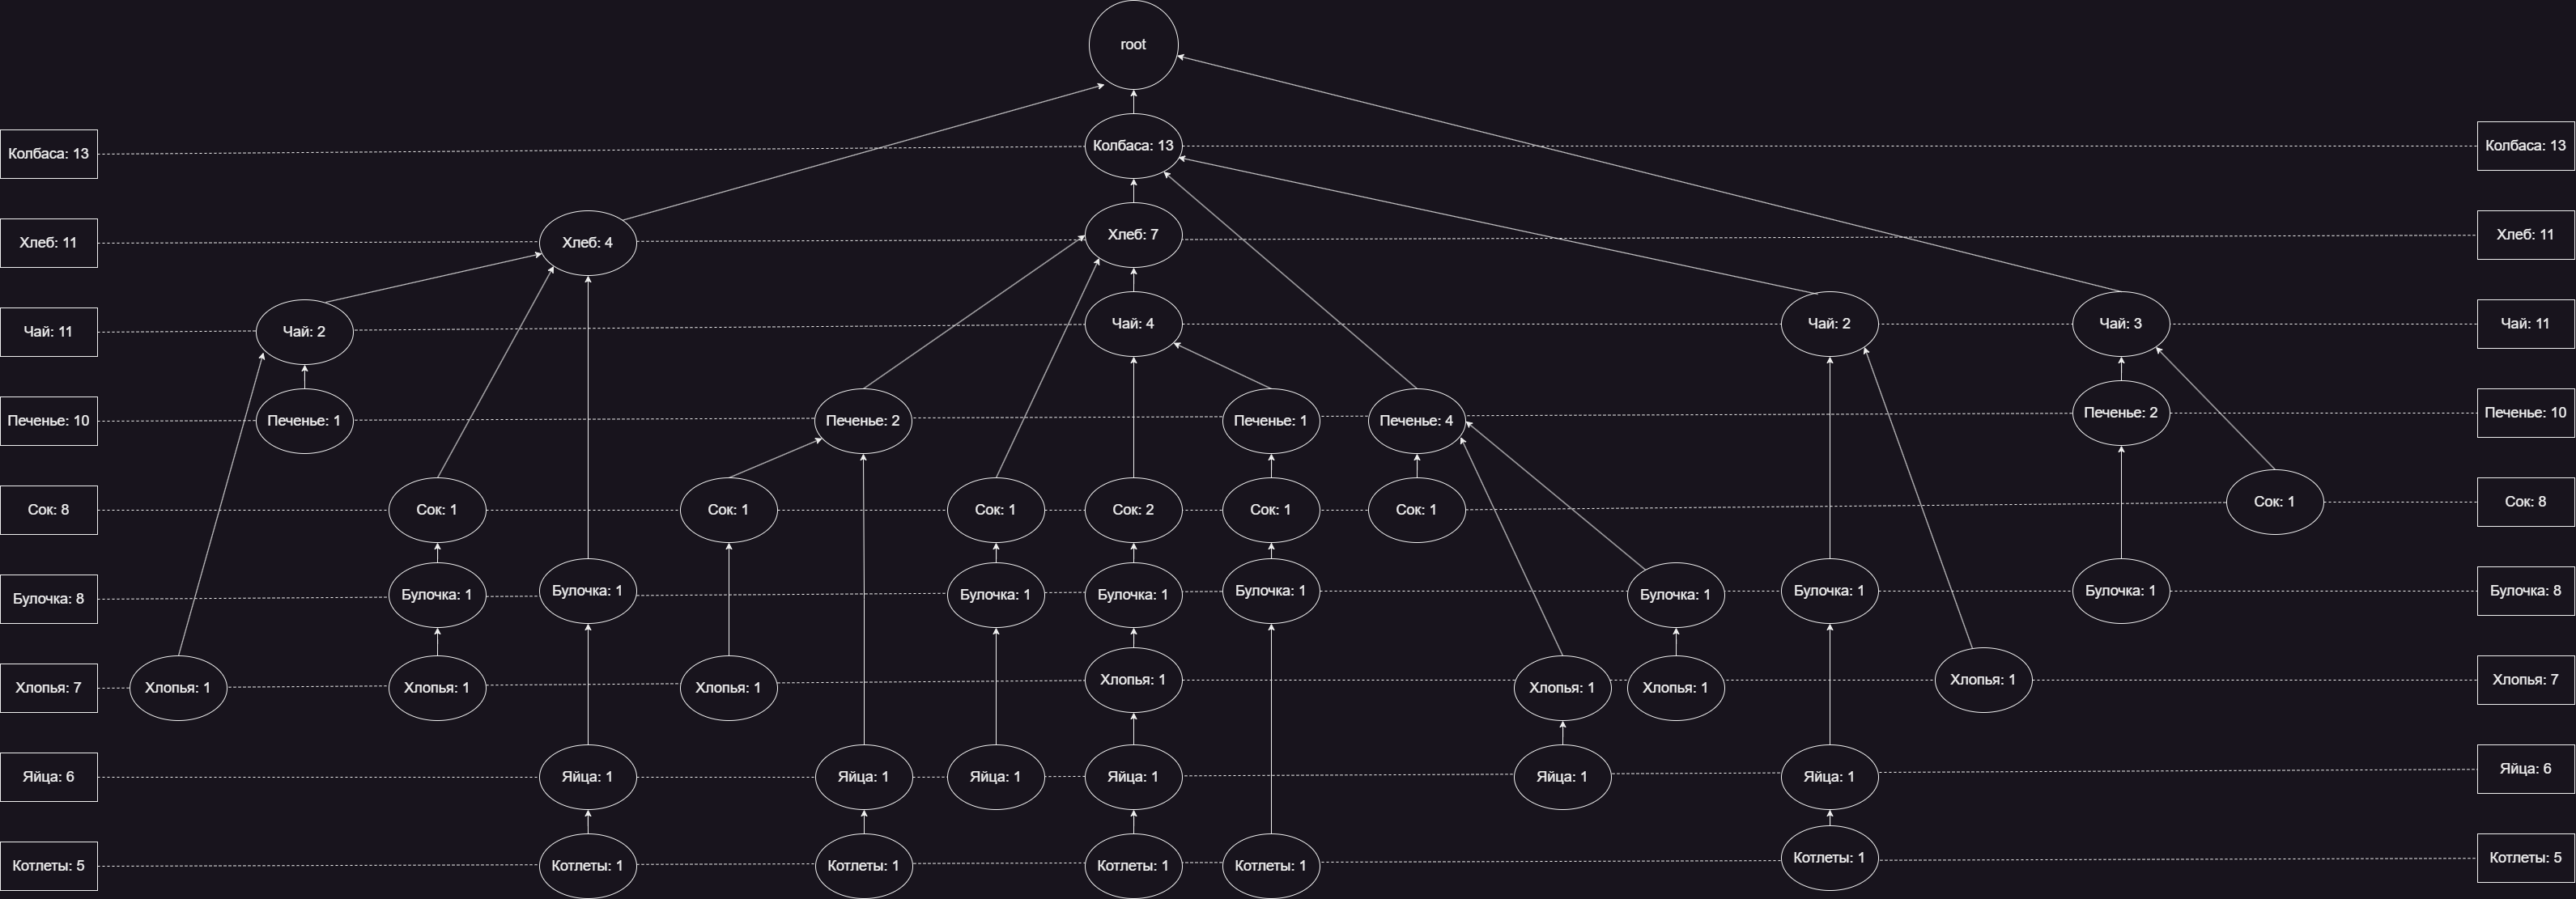

Теперь смотрим, как выглядит дерево для каждого товара, снизу вверх

#### Котлеты

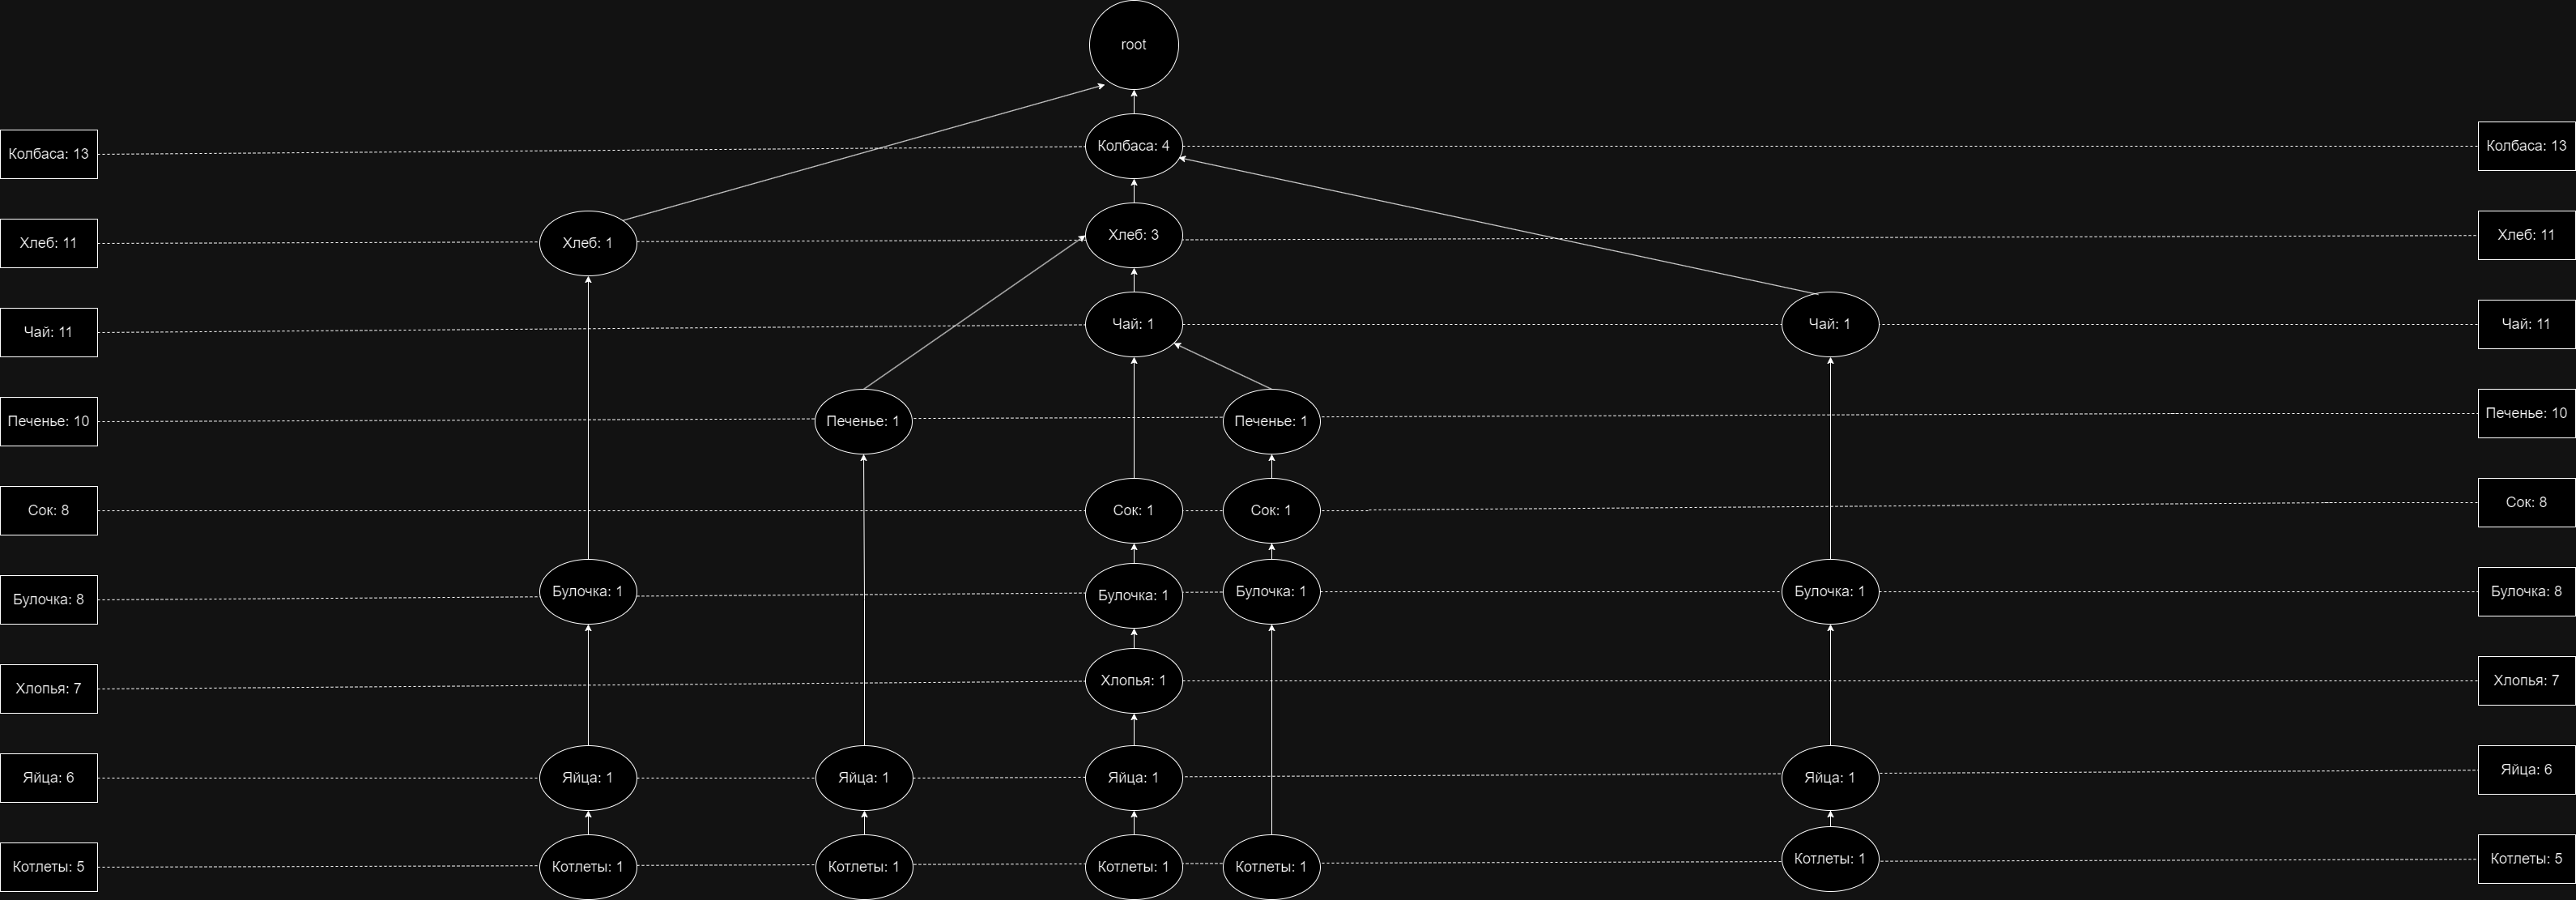

И после прохождения порога дельта = 5 ничего не останется
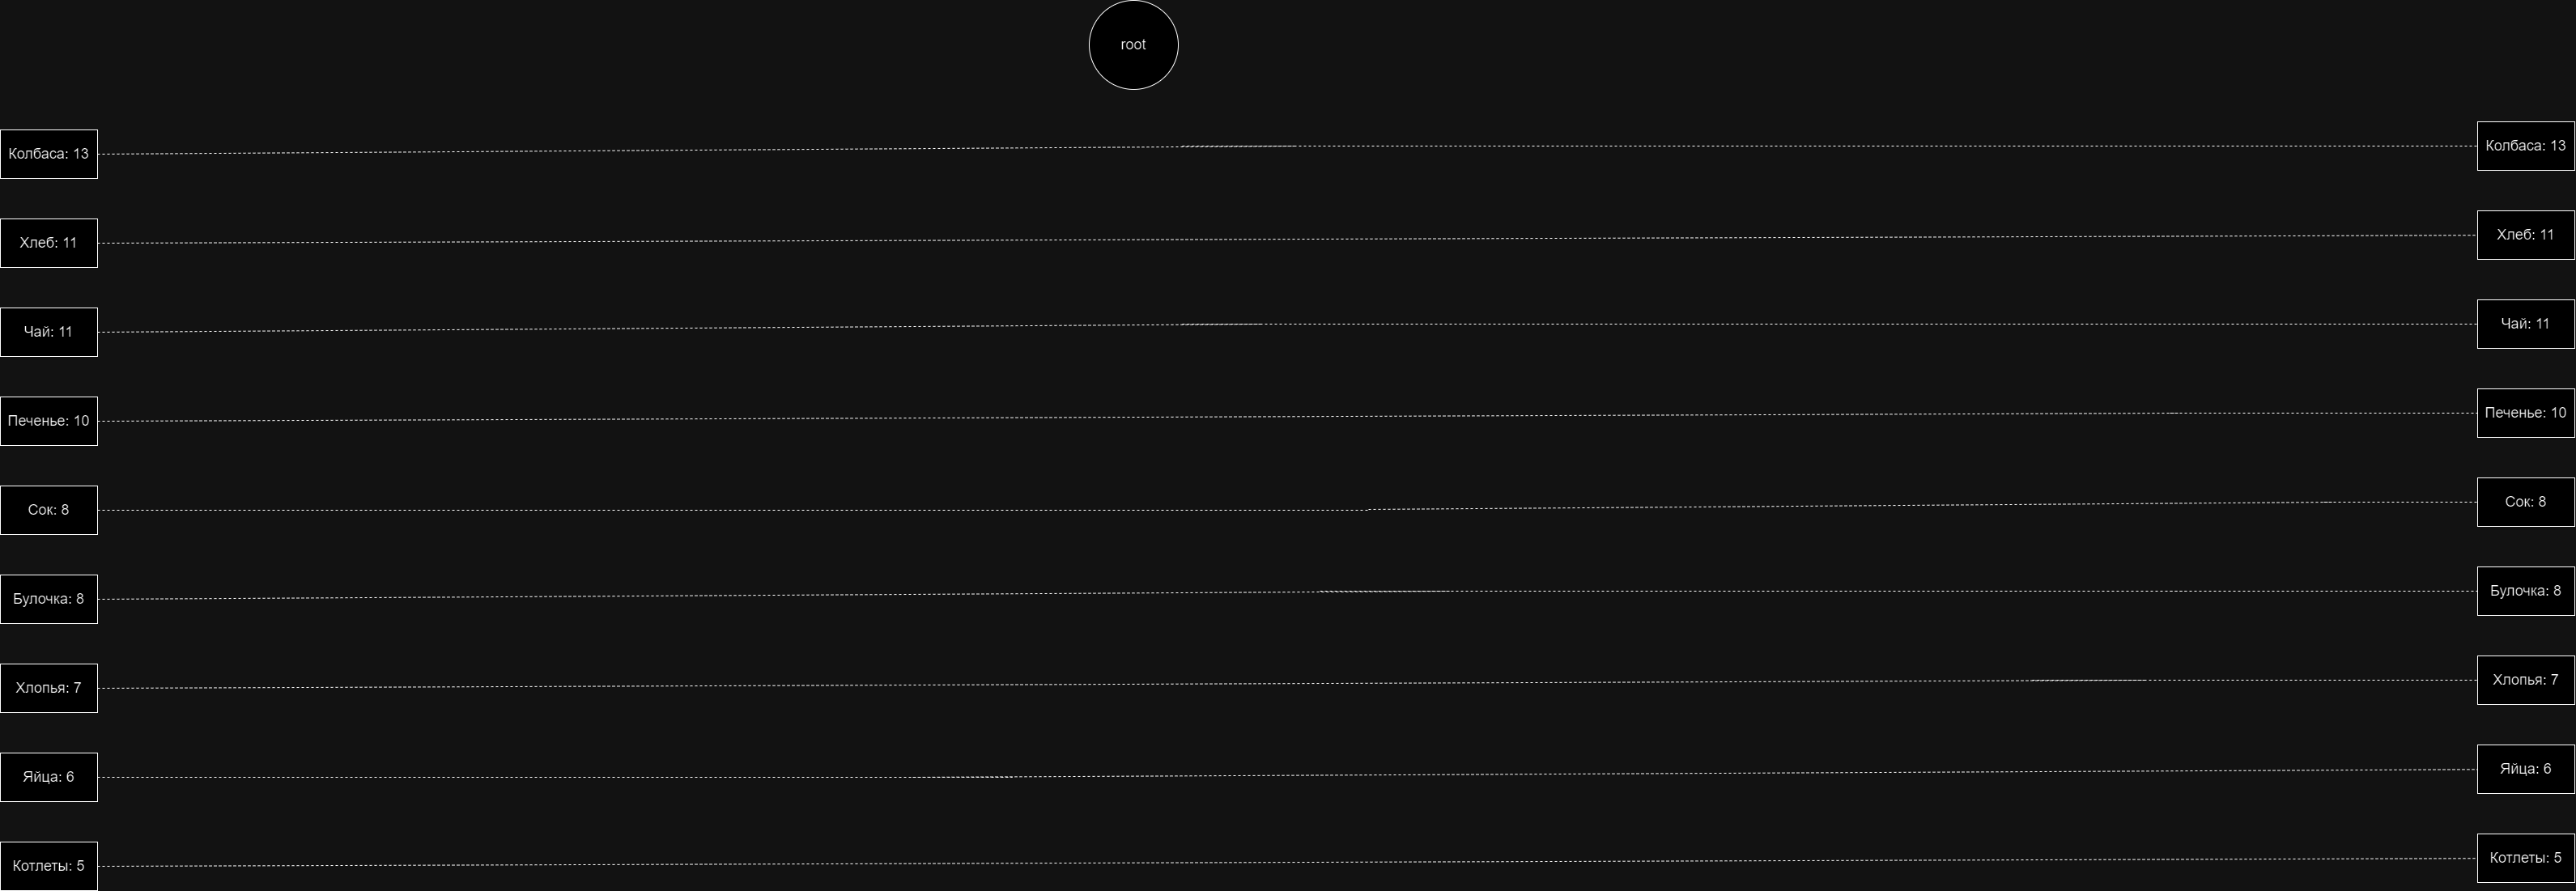

#### Яйца

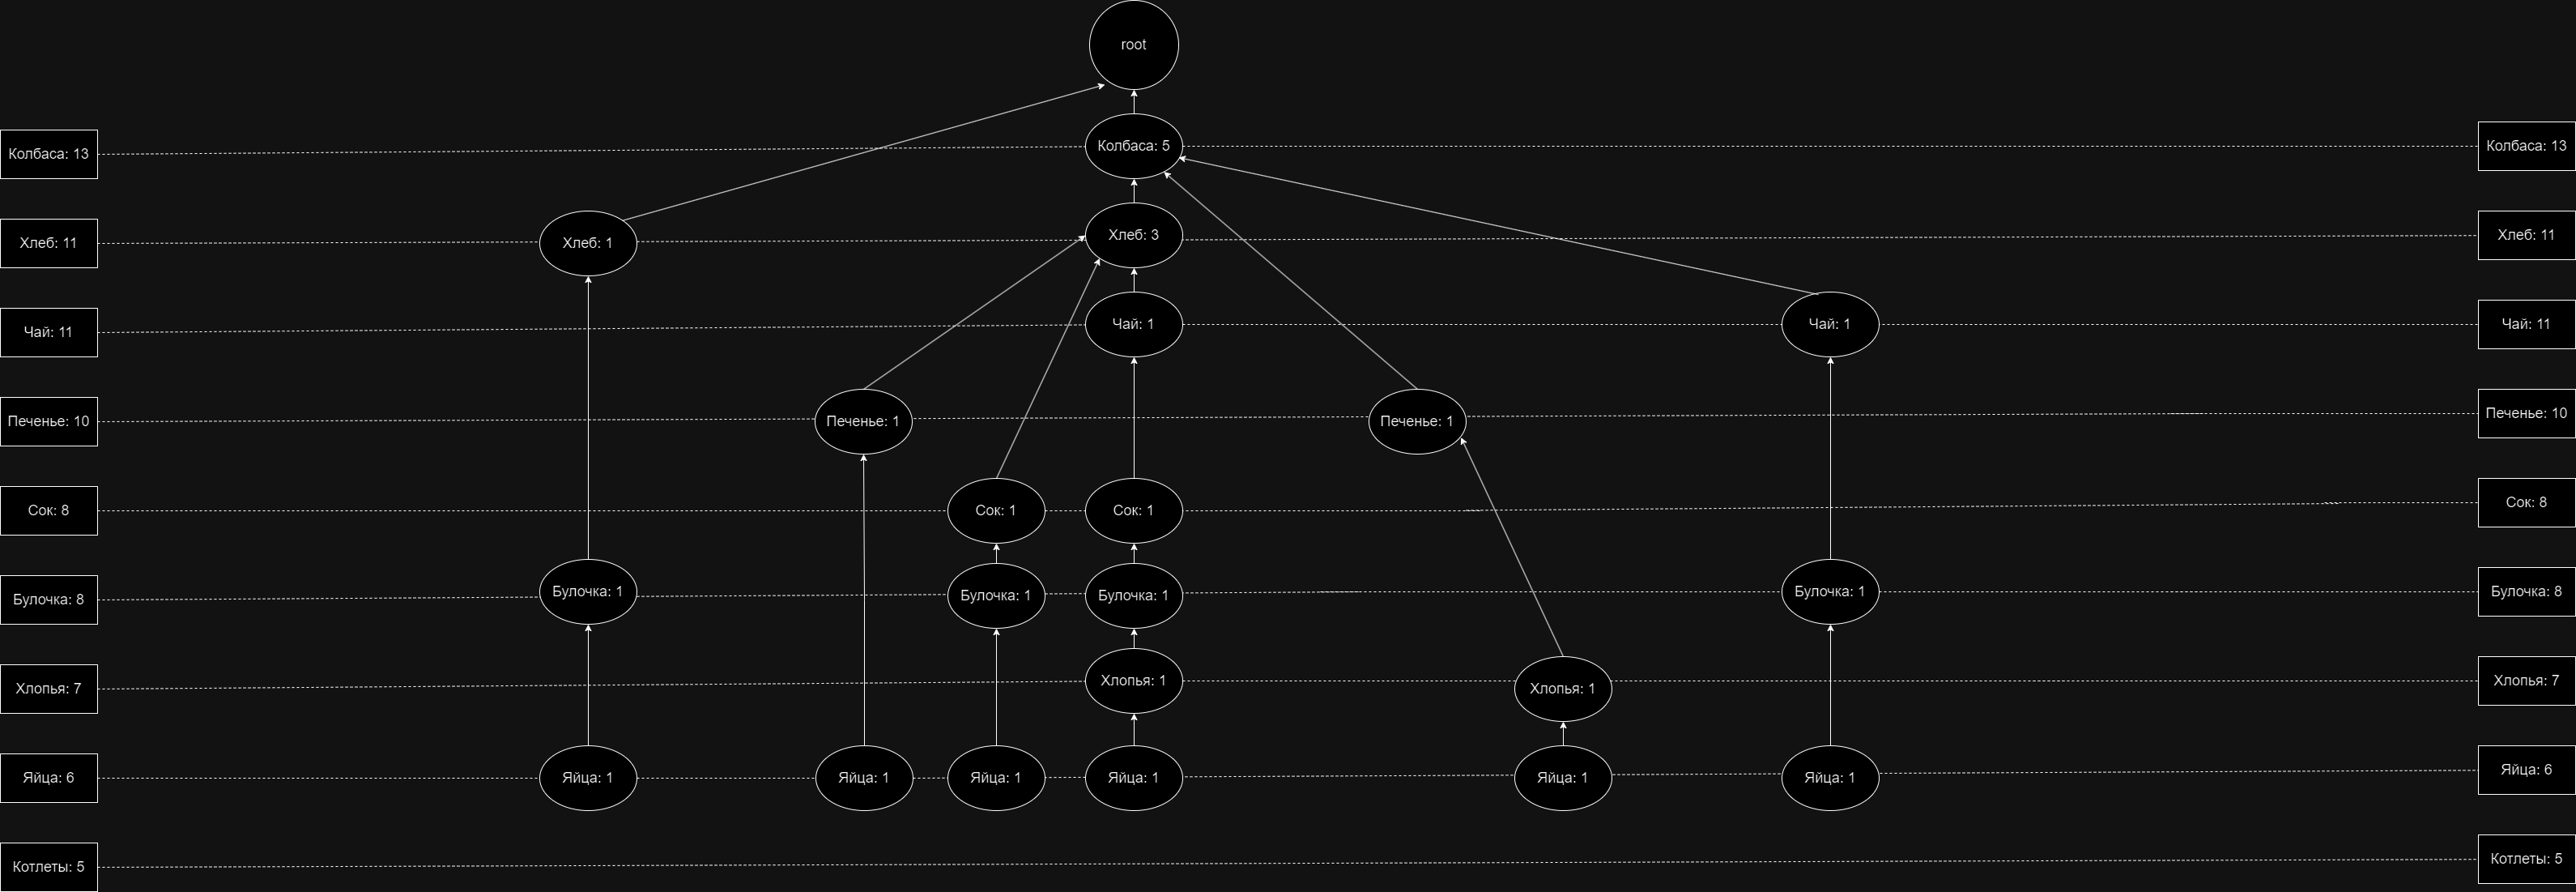

И после порога - осталась 1 связь, с колбасой
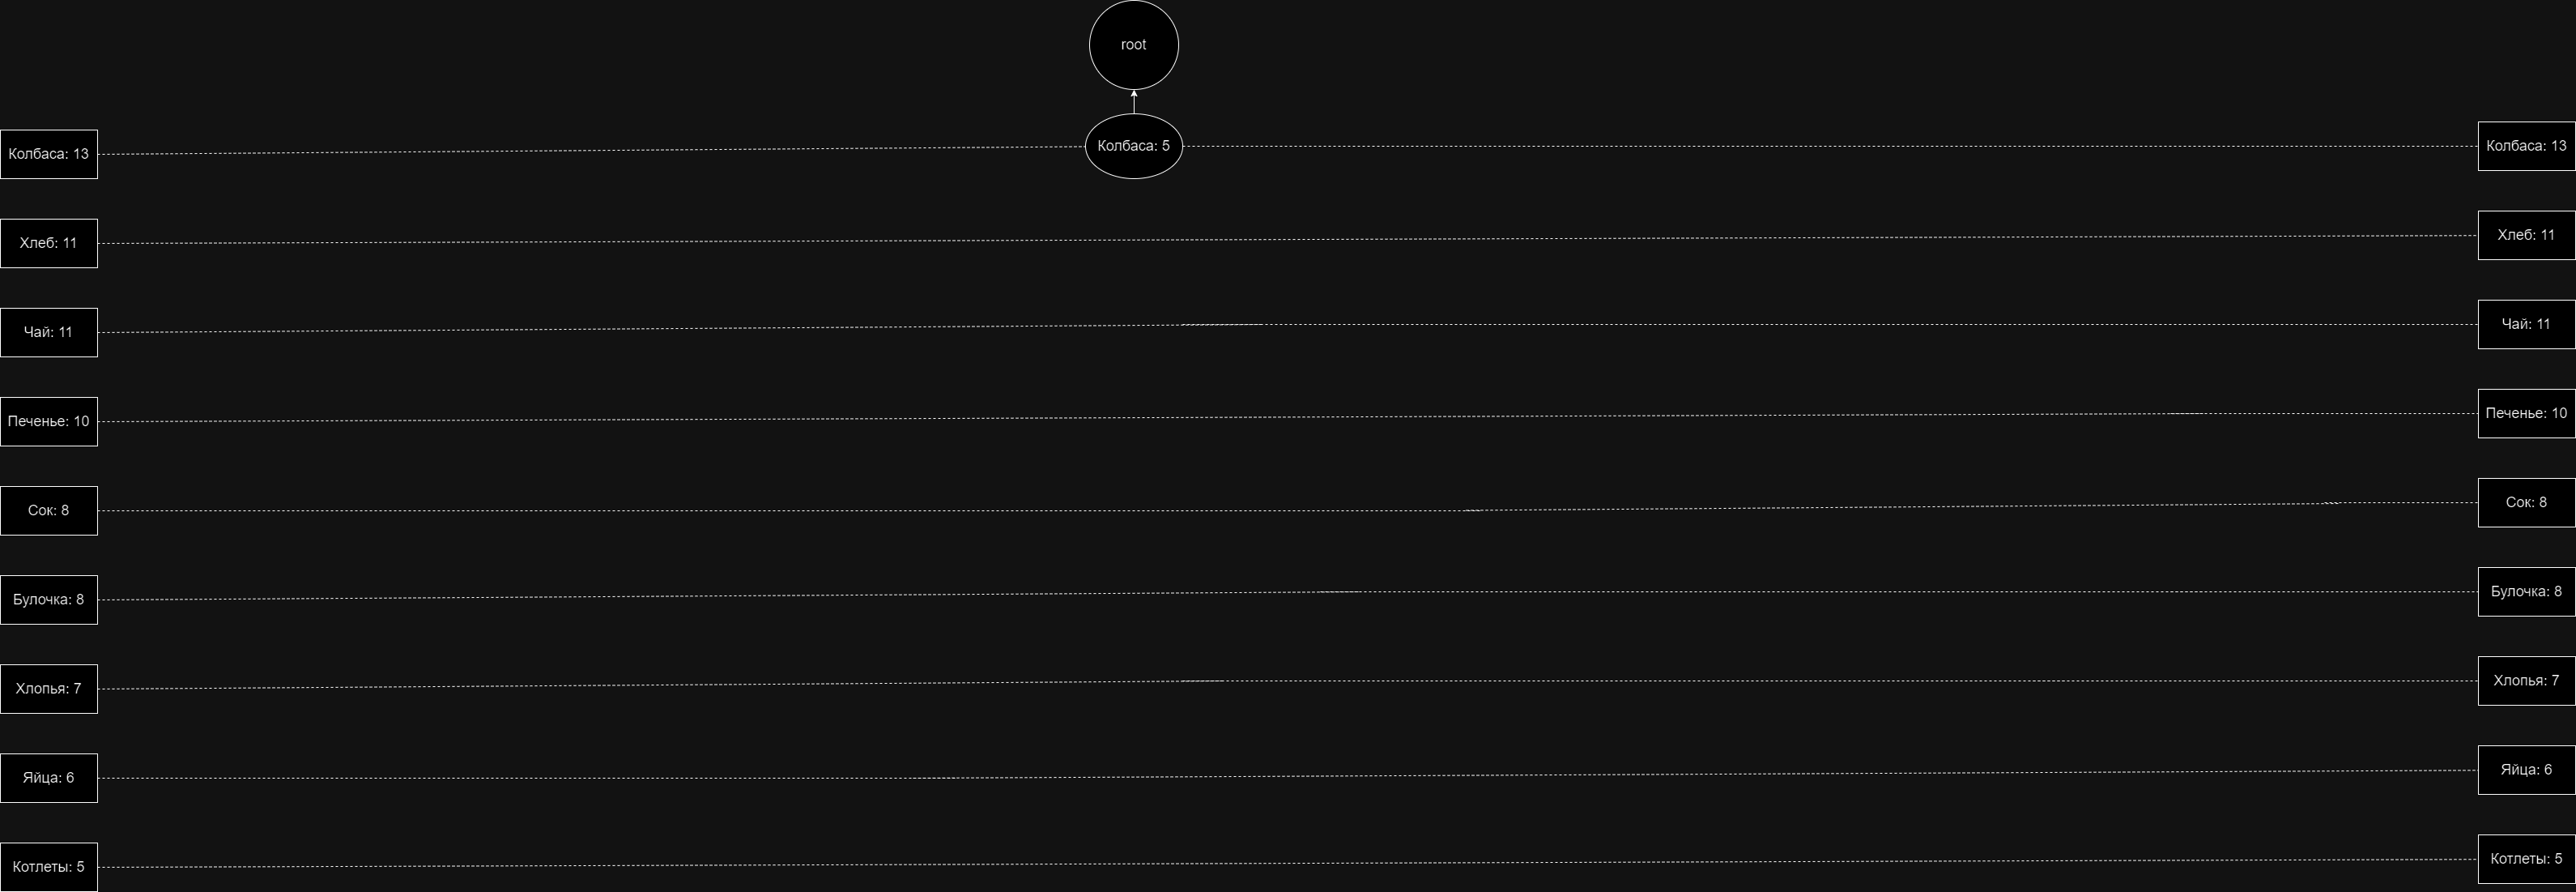

#### Хлопья

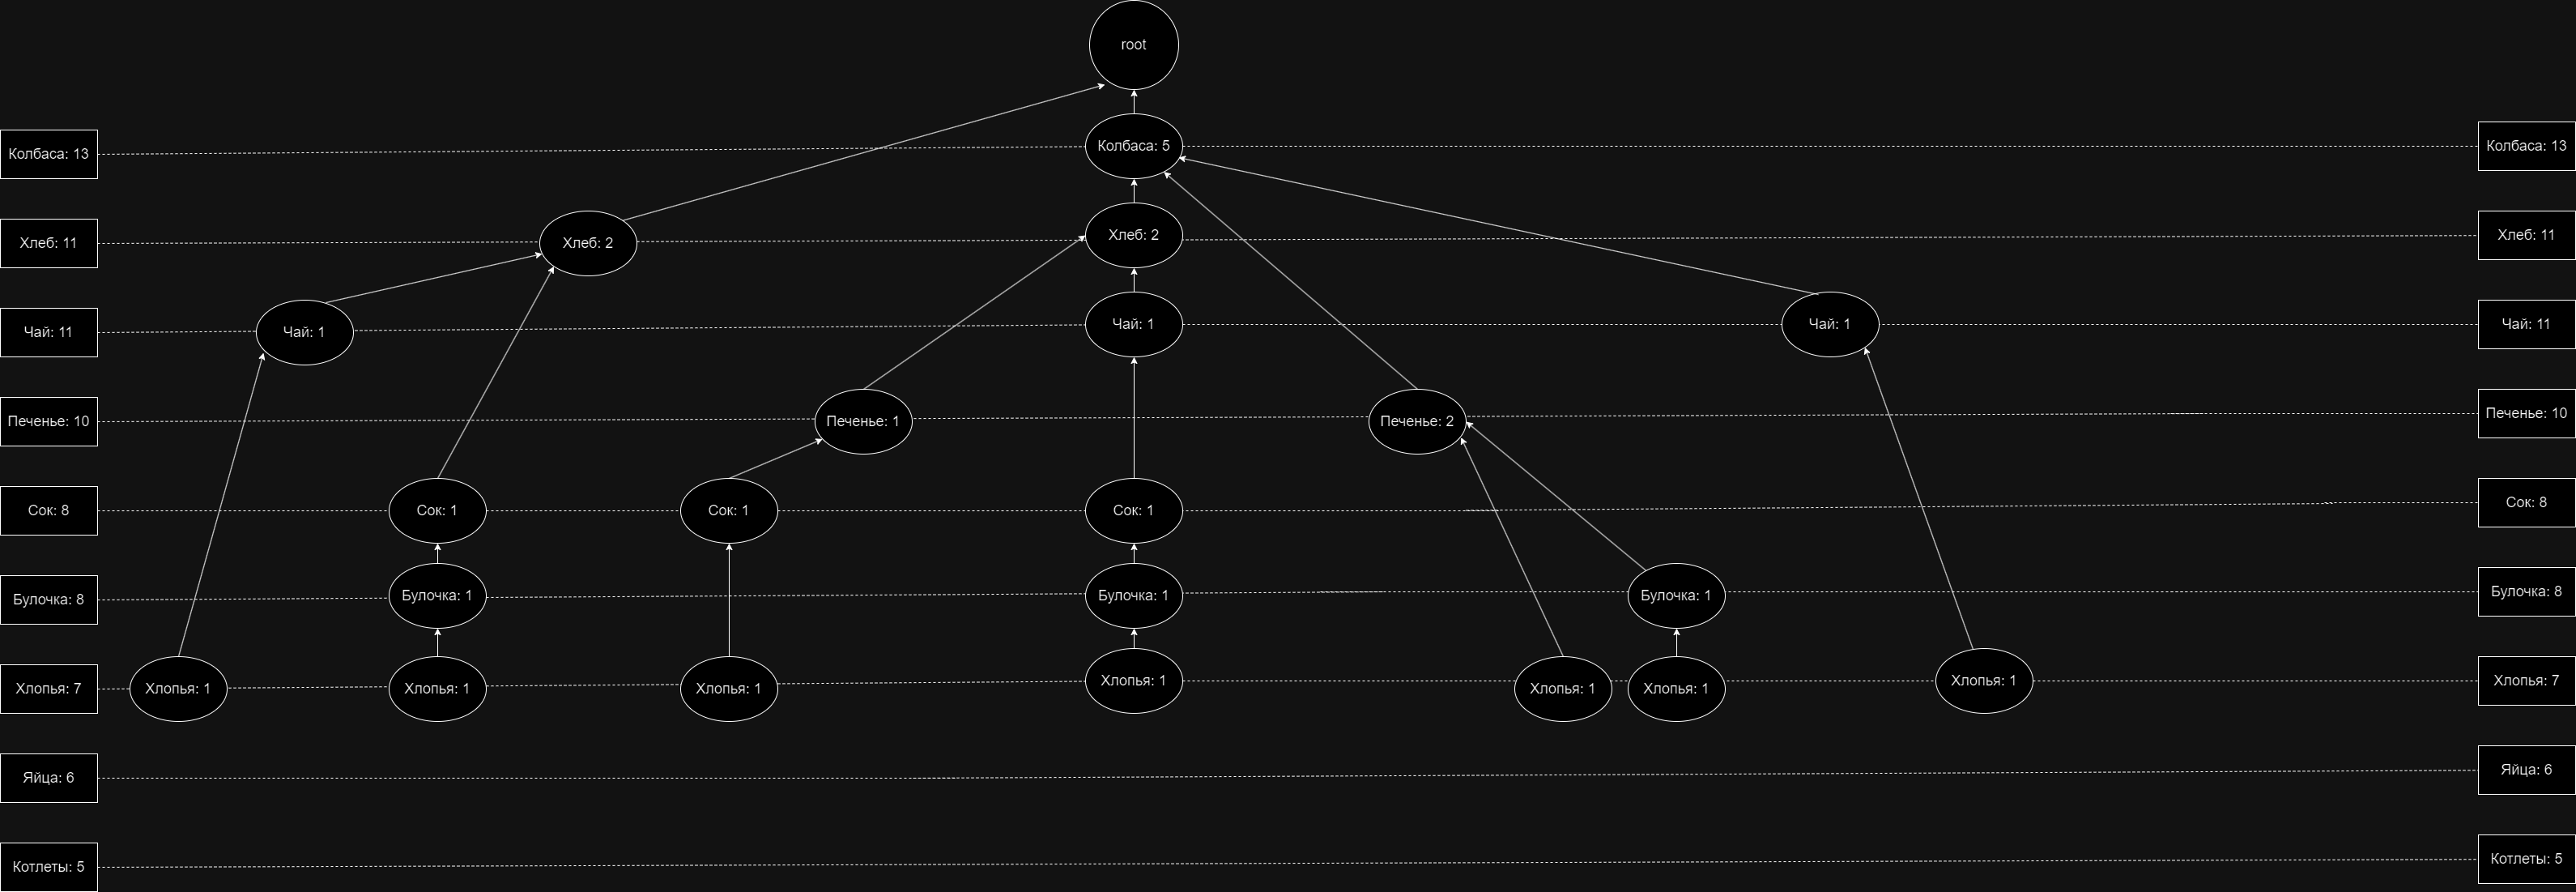

И после порога - тоже одна связь с колбасой
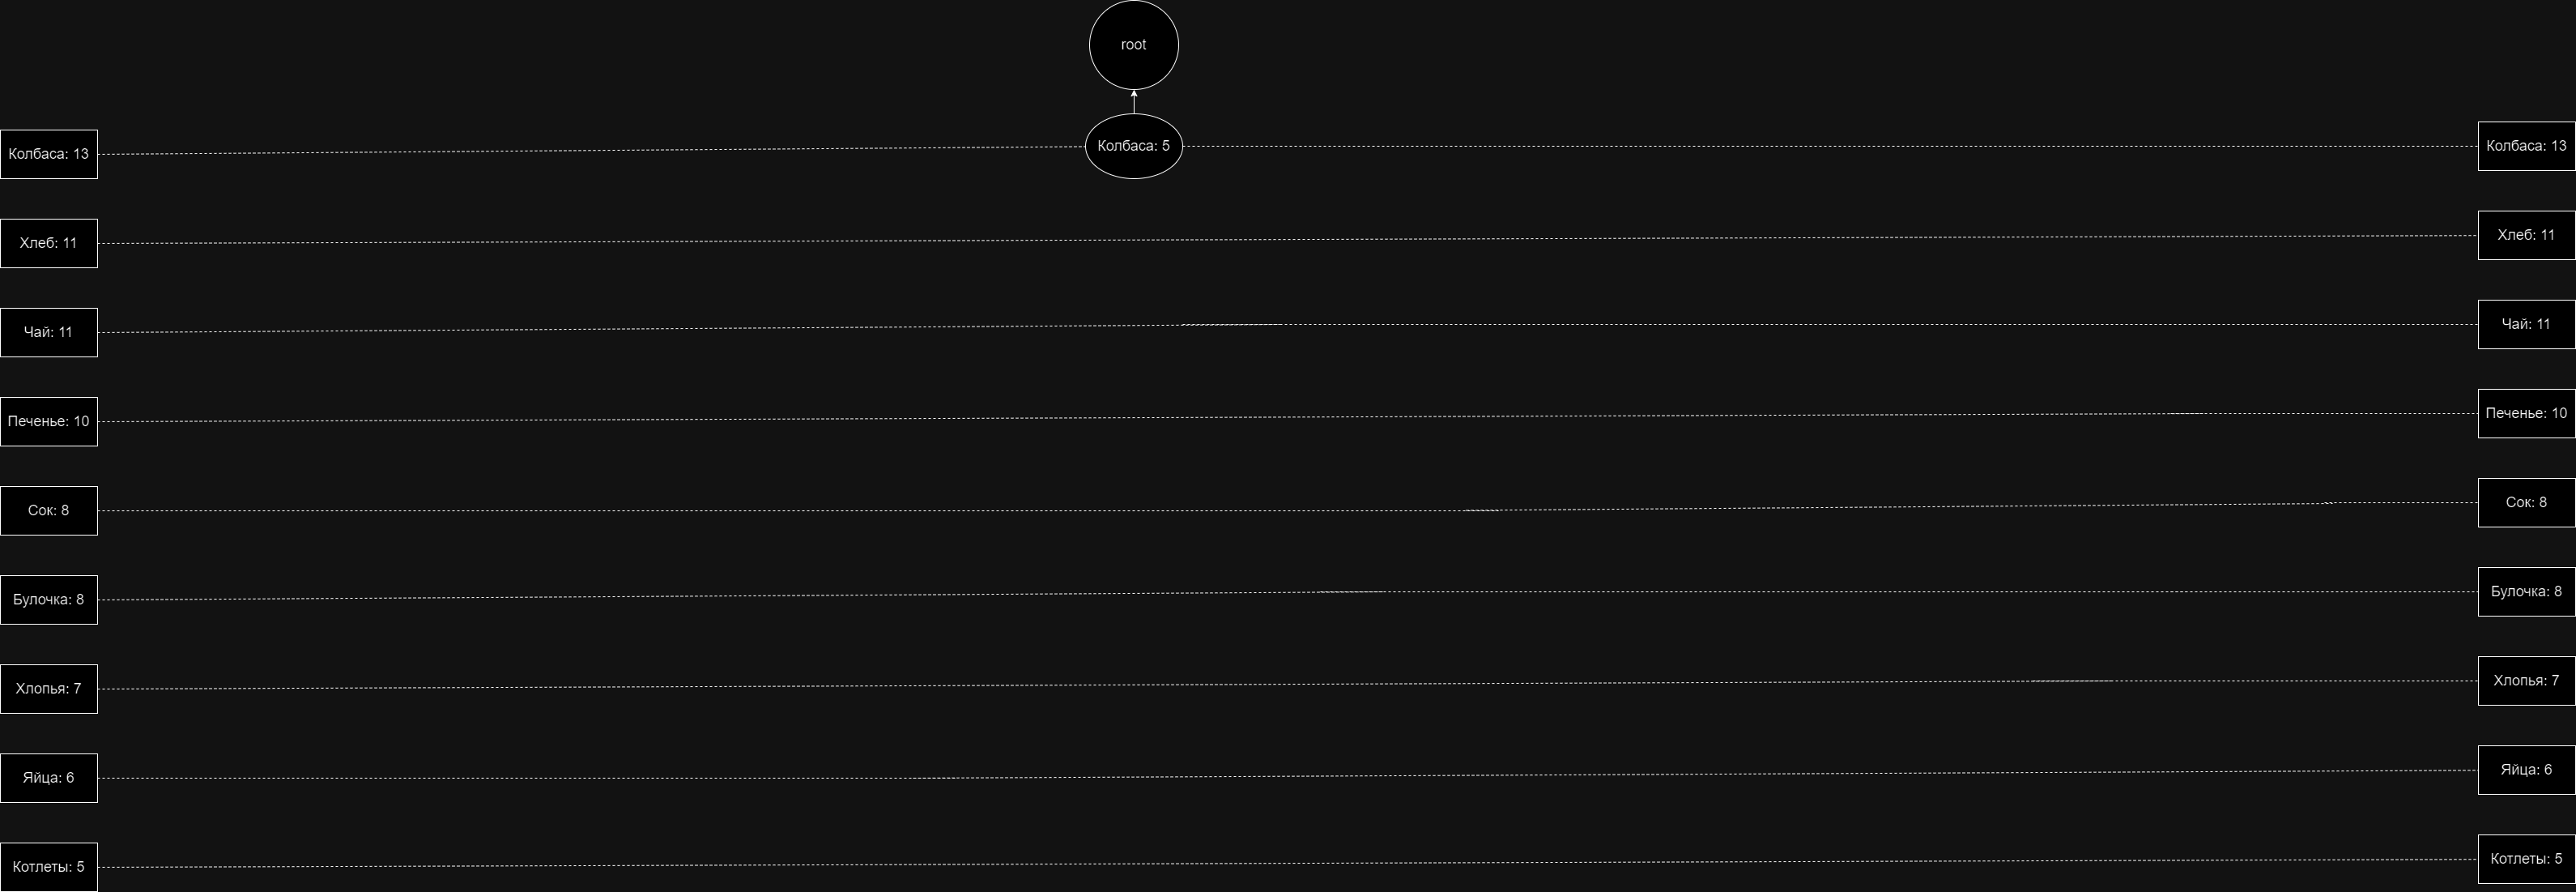

#### Булочка

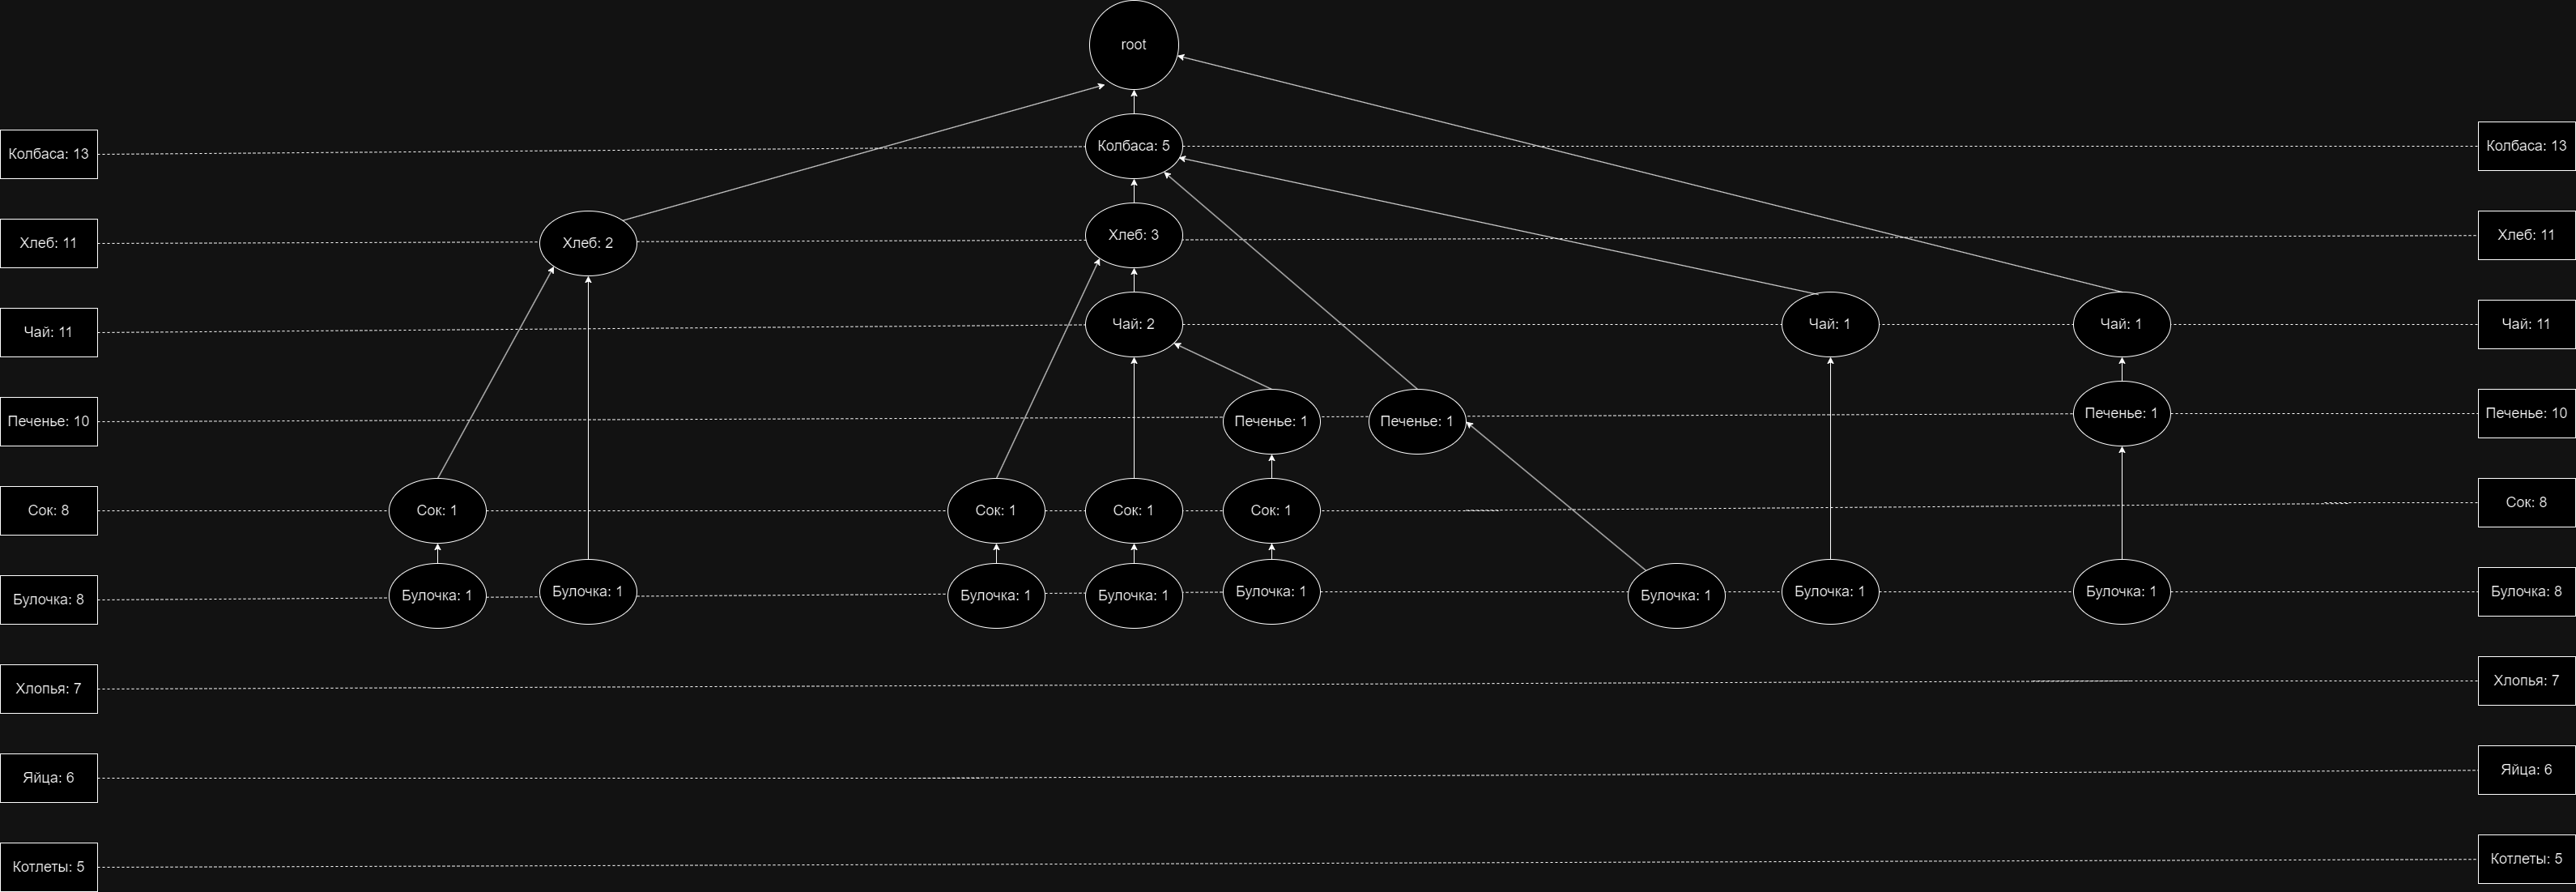

После очистки - осталось две связи, но одиночные, (?) с колбасой и с хлебом
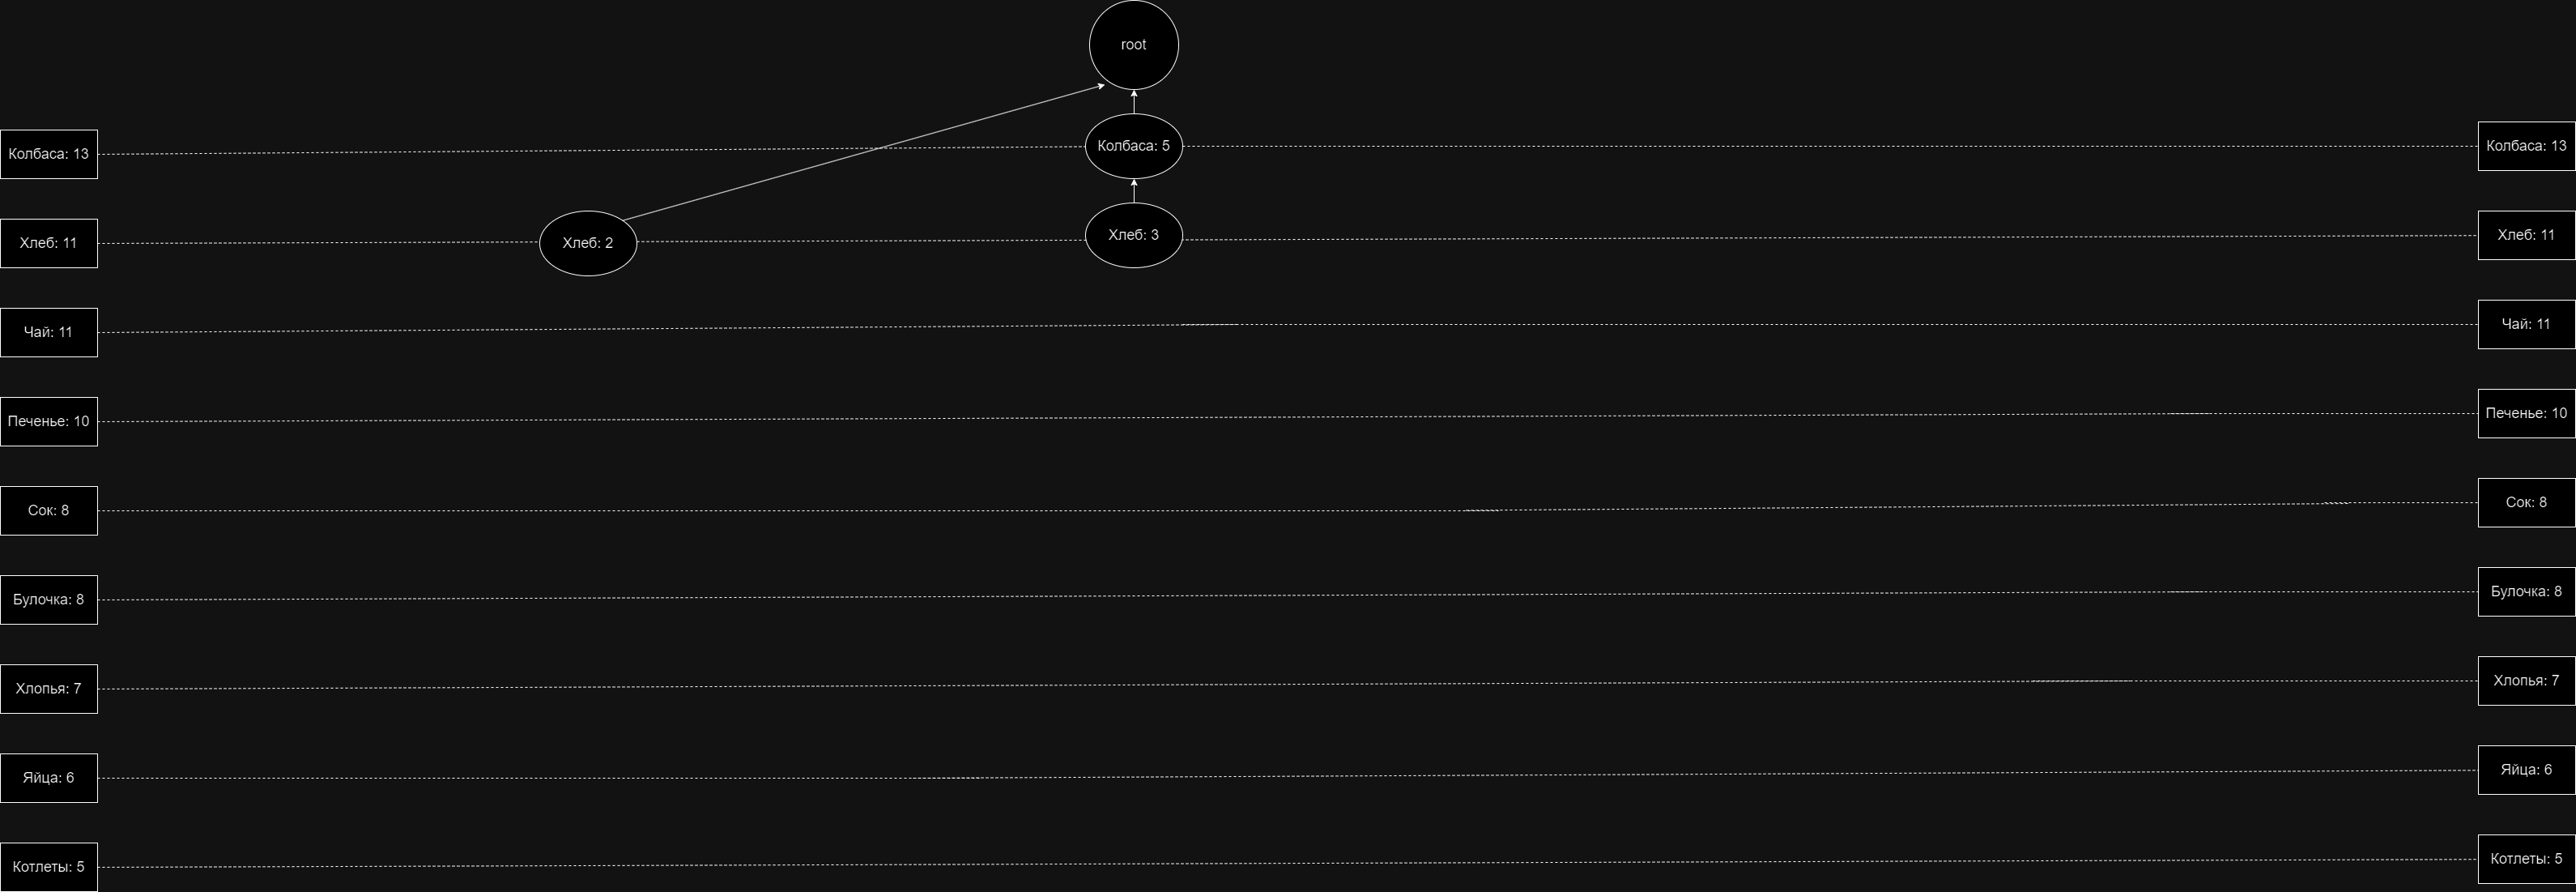

#### Сок

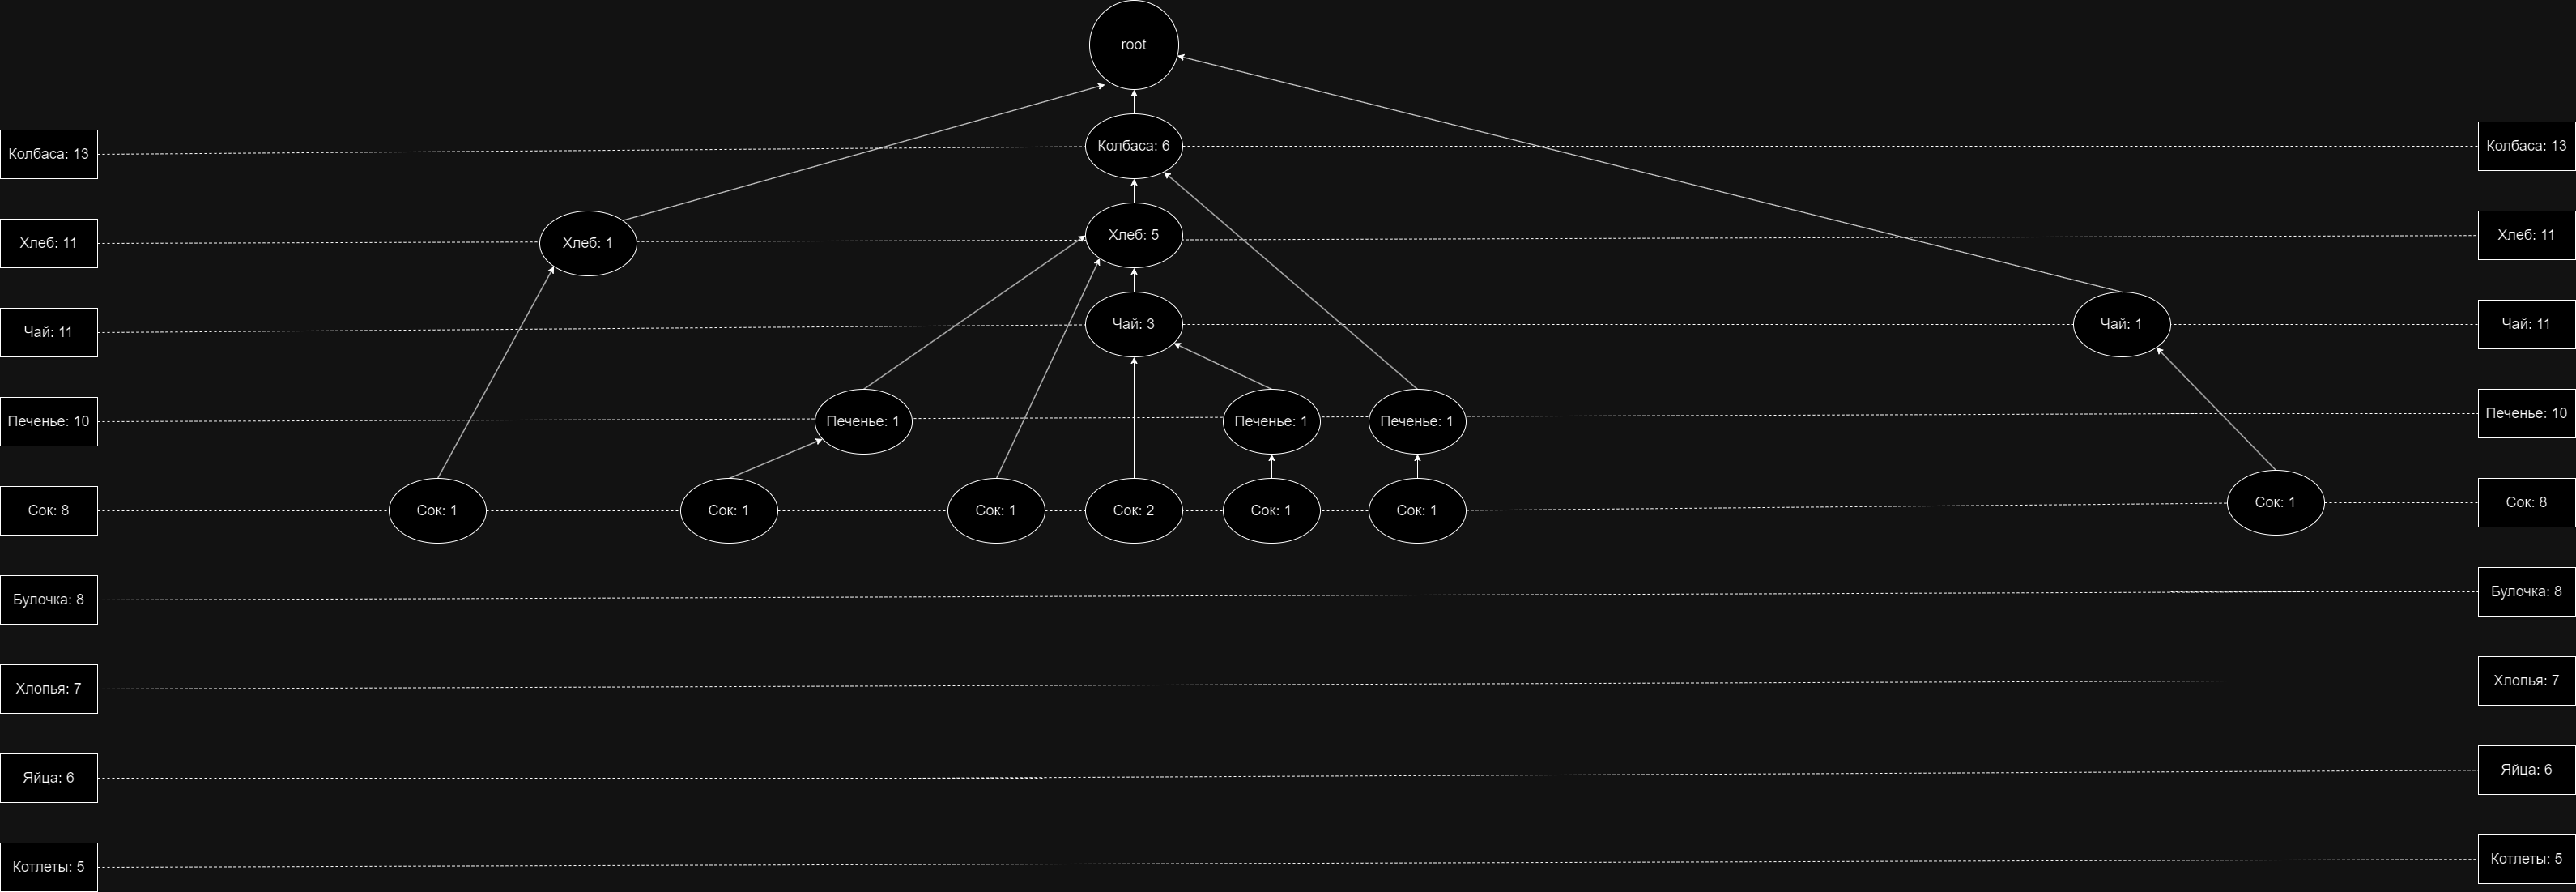

Тут как раз вырисовывается единственная тройка частых товаров, которые покупают вместе - колбаса и хлеб вместе с соком
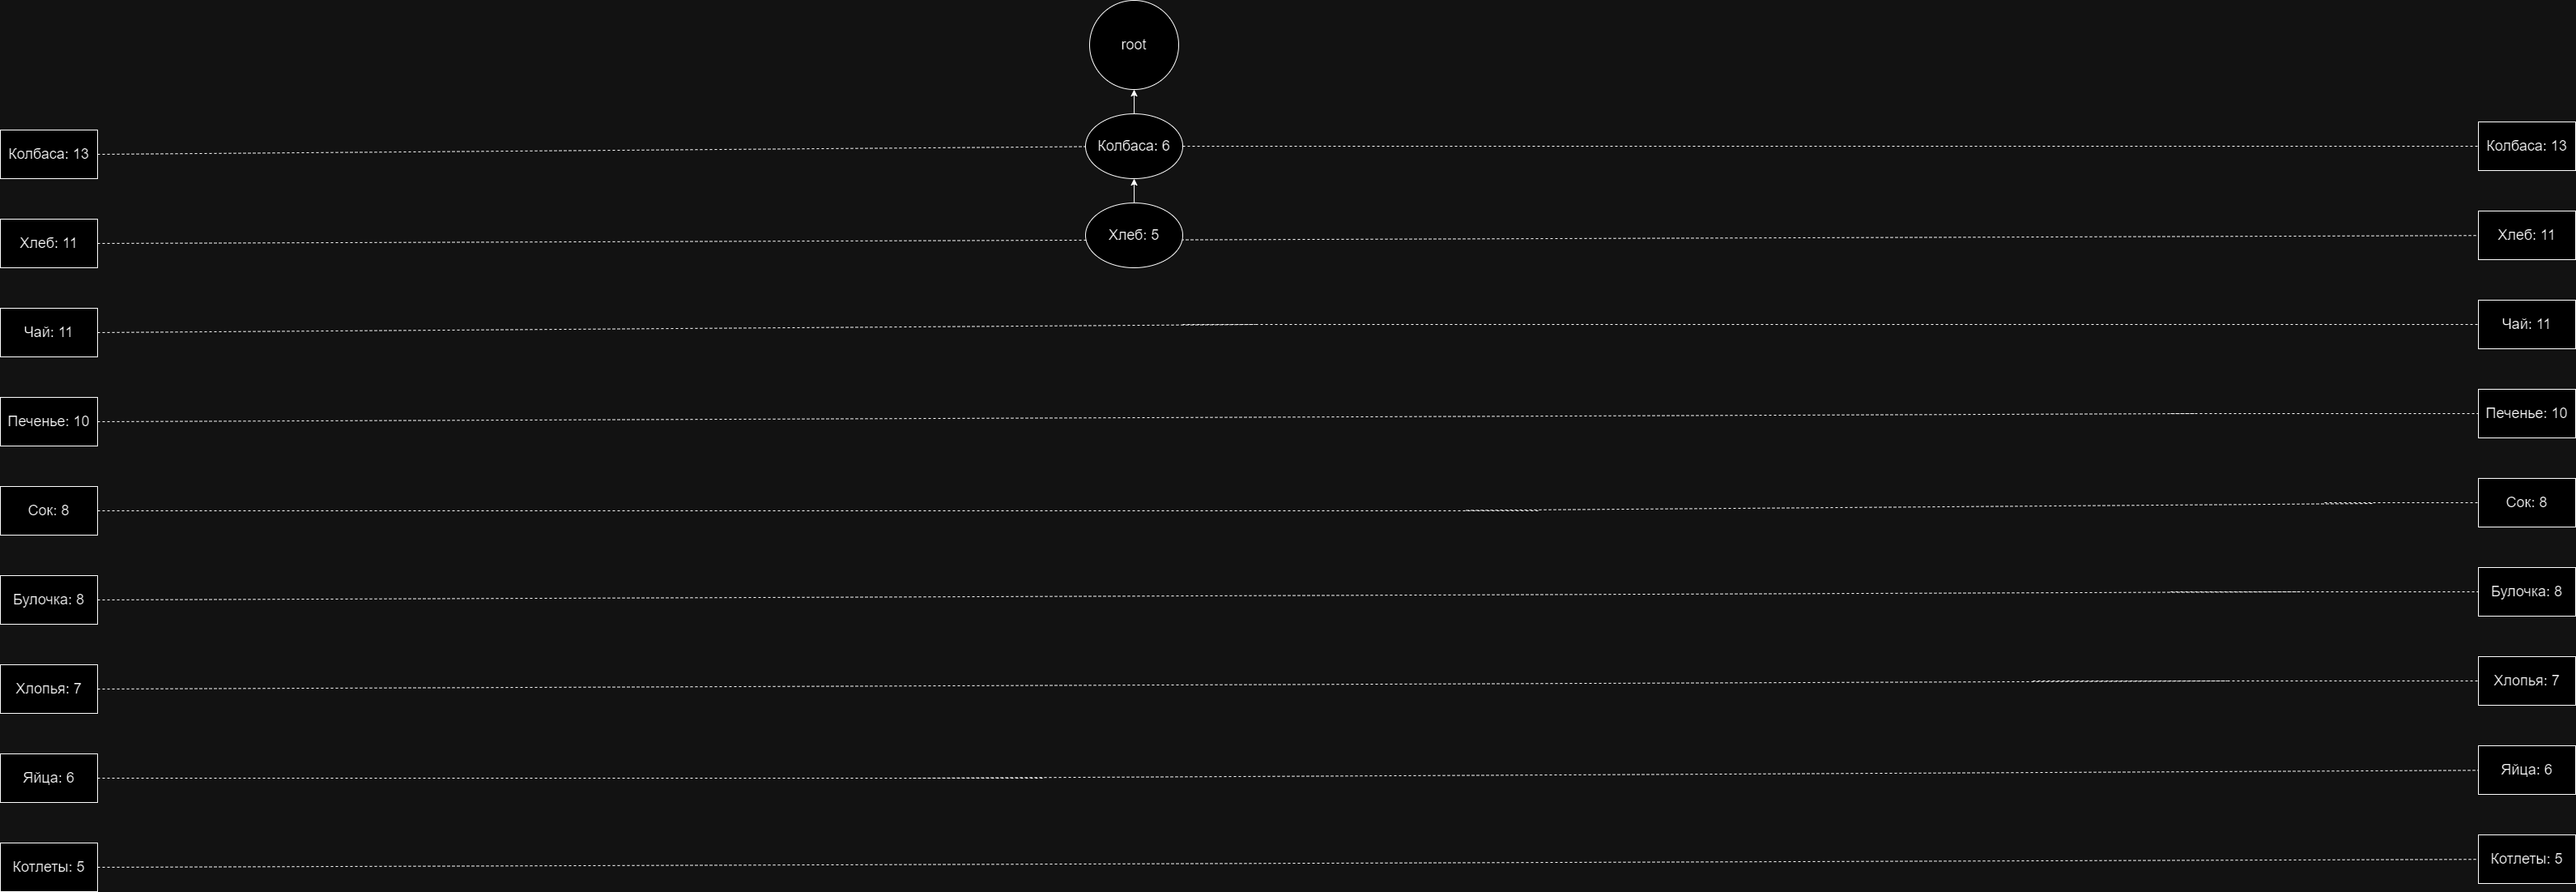

#### Печенье

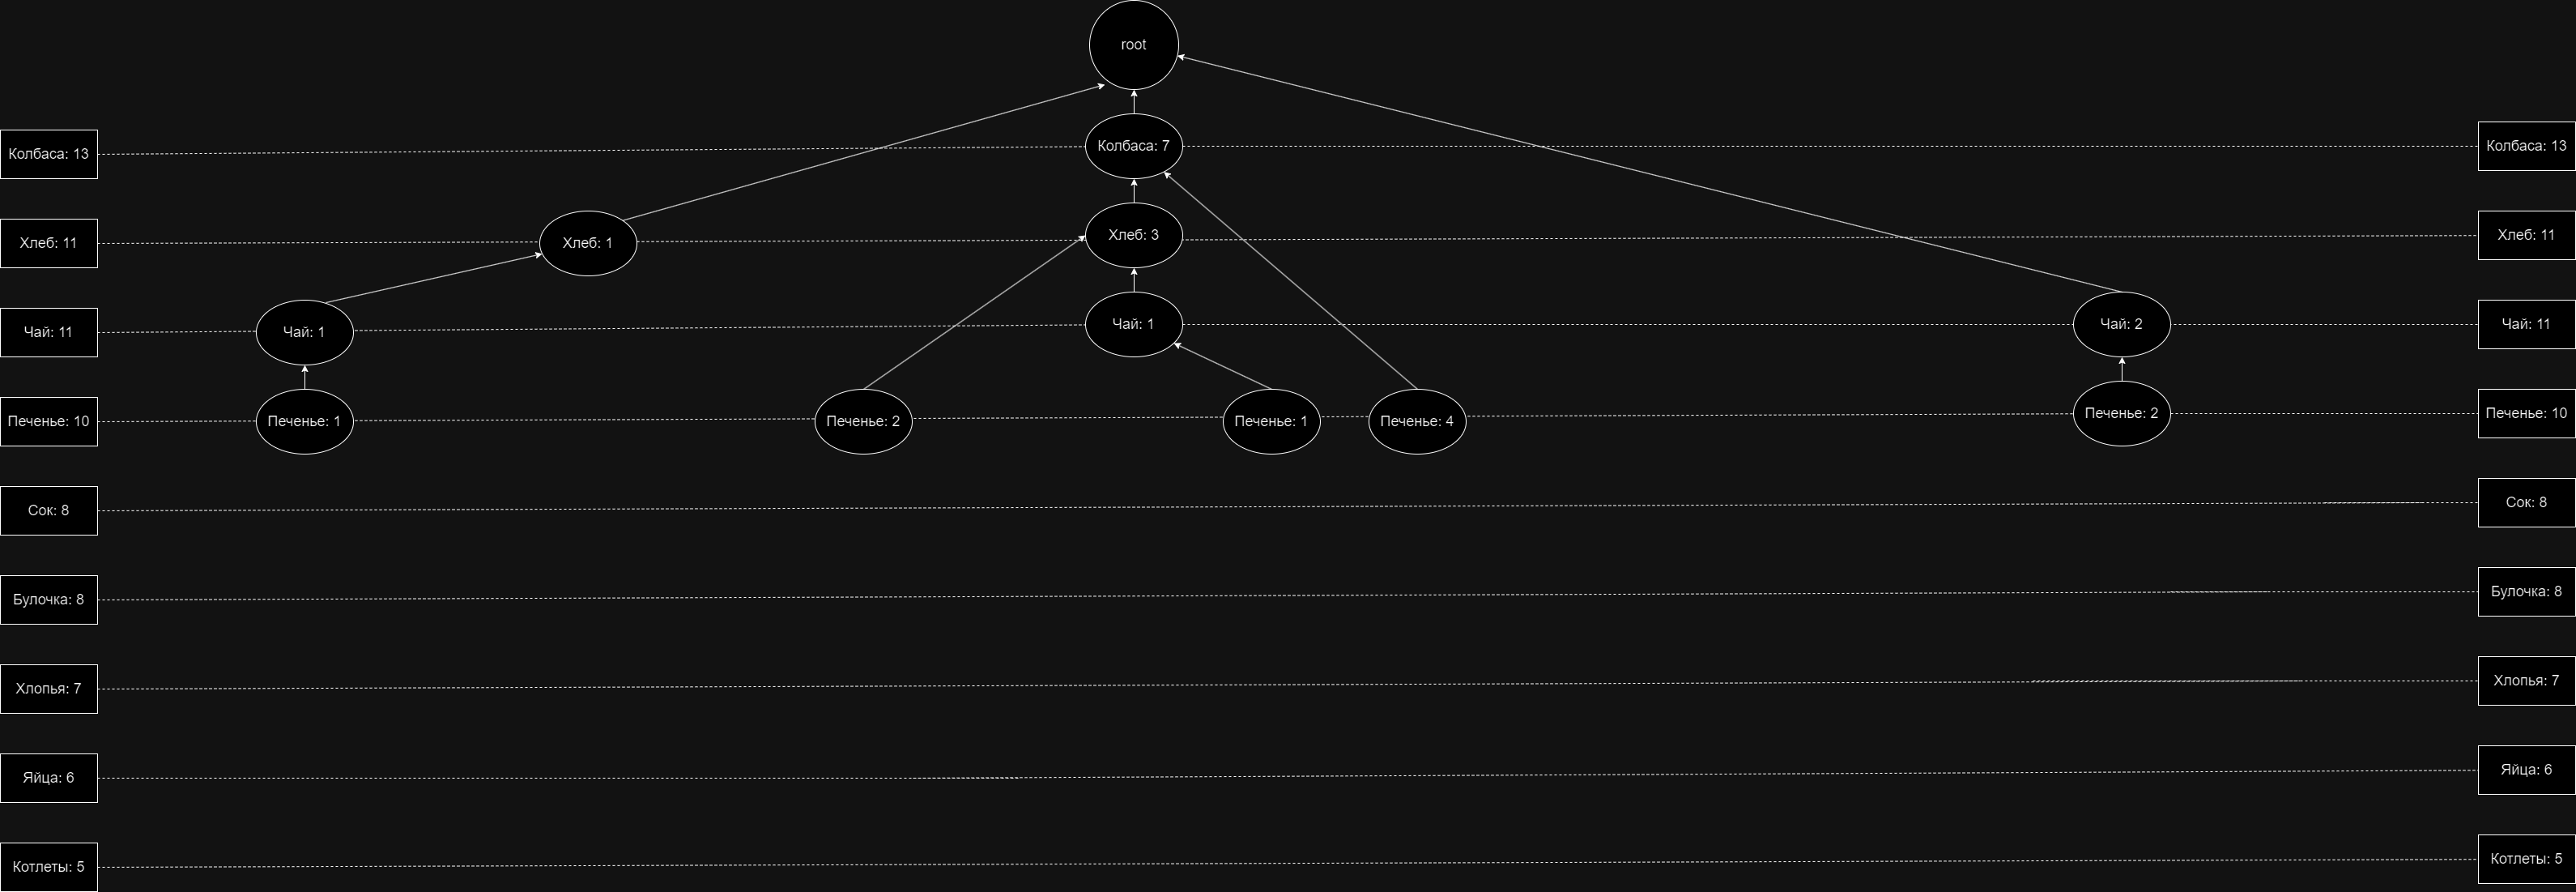

Тут только колбаса
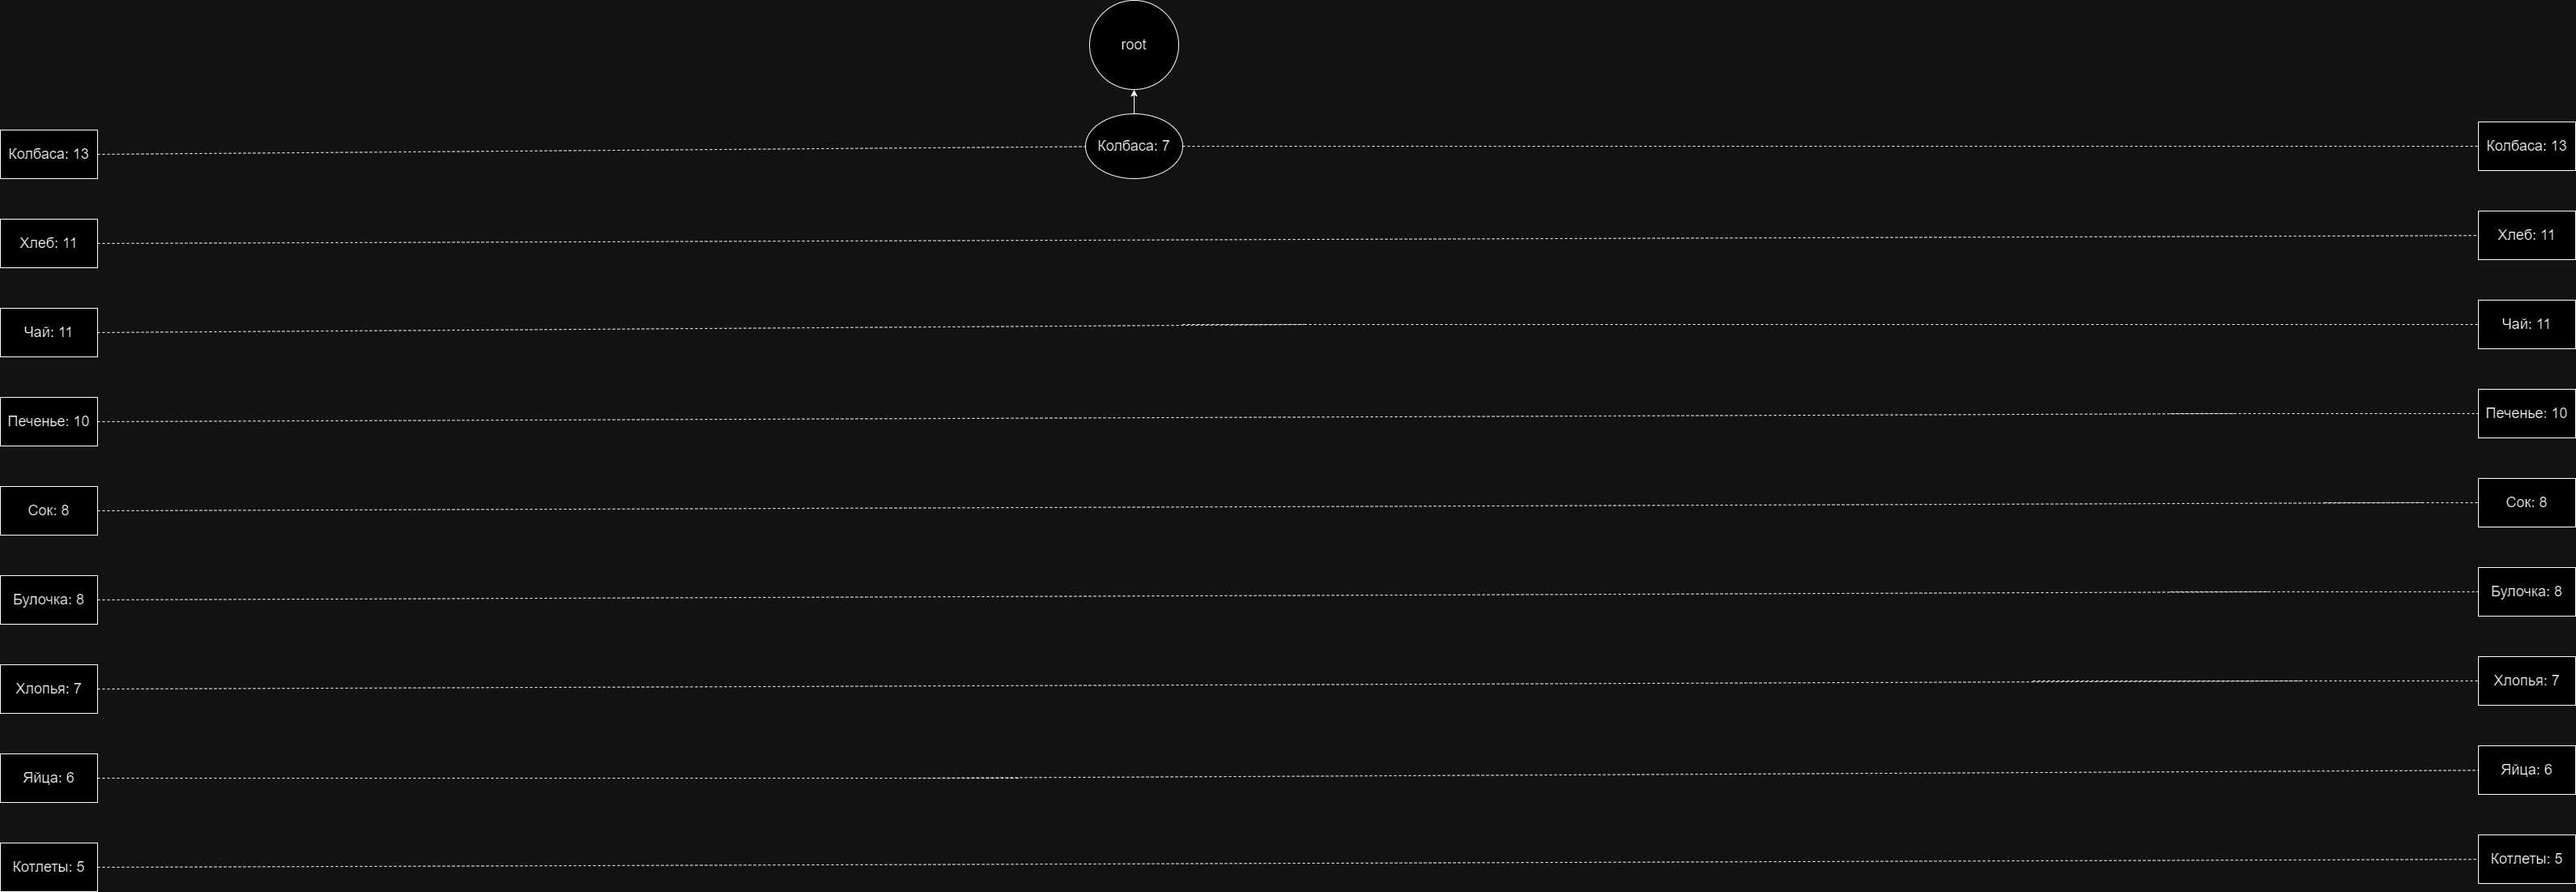

#### Чай

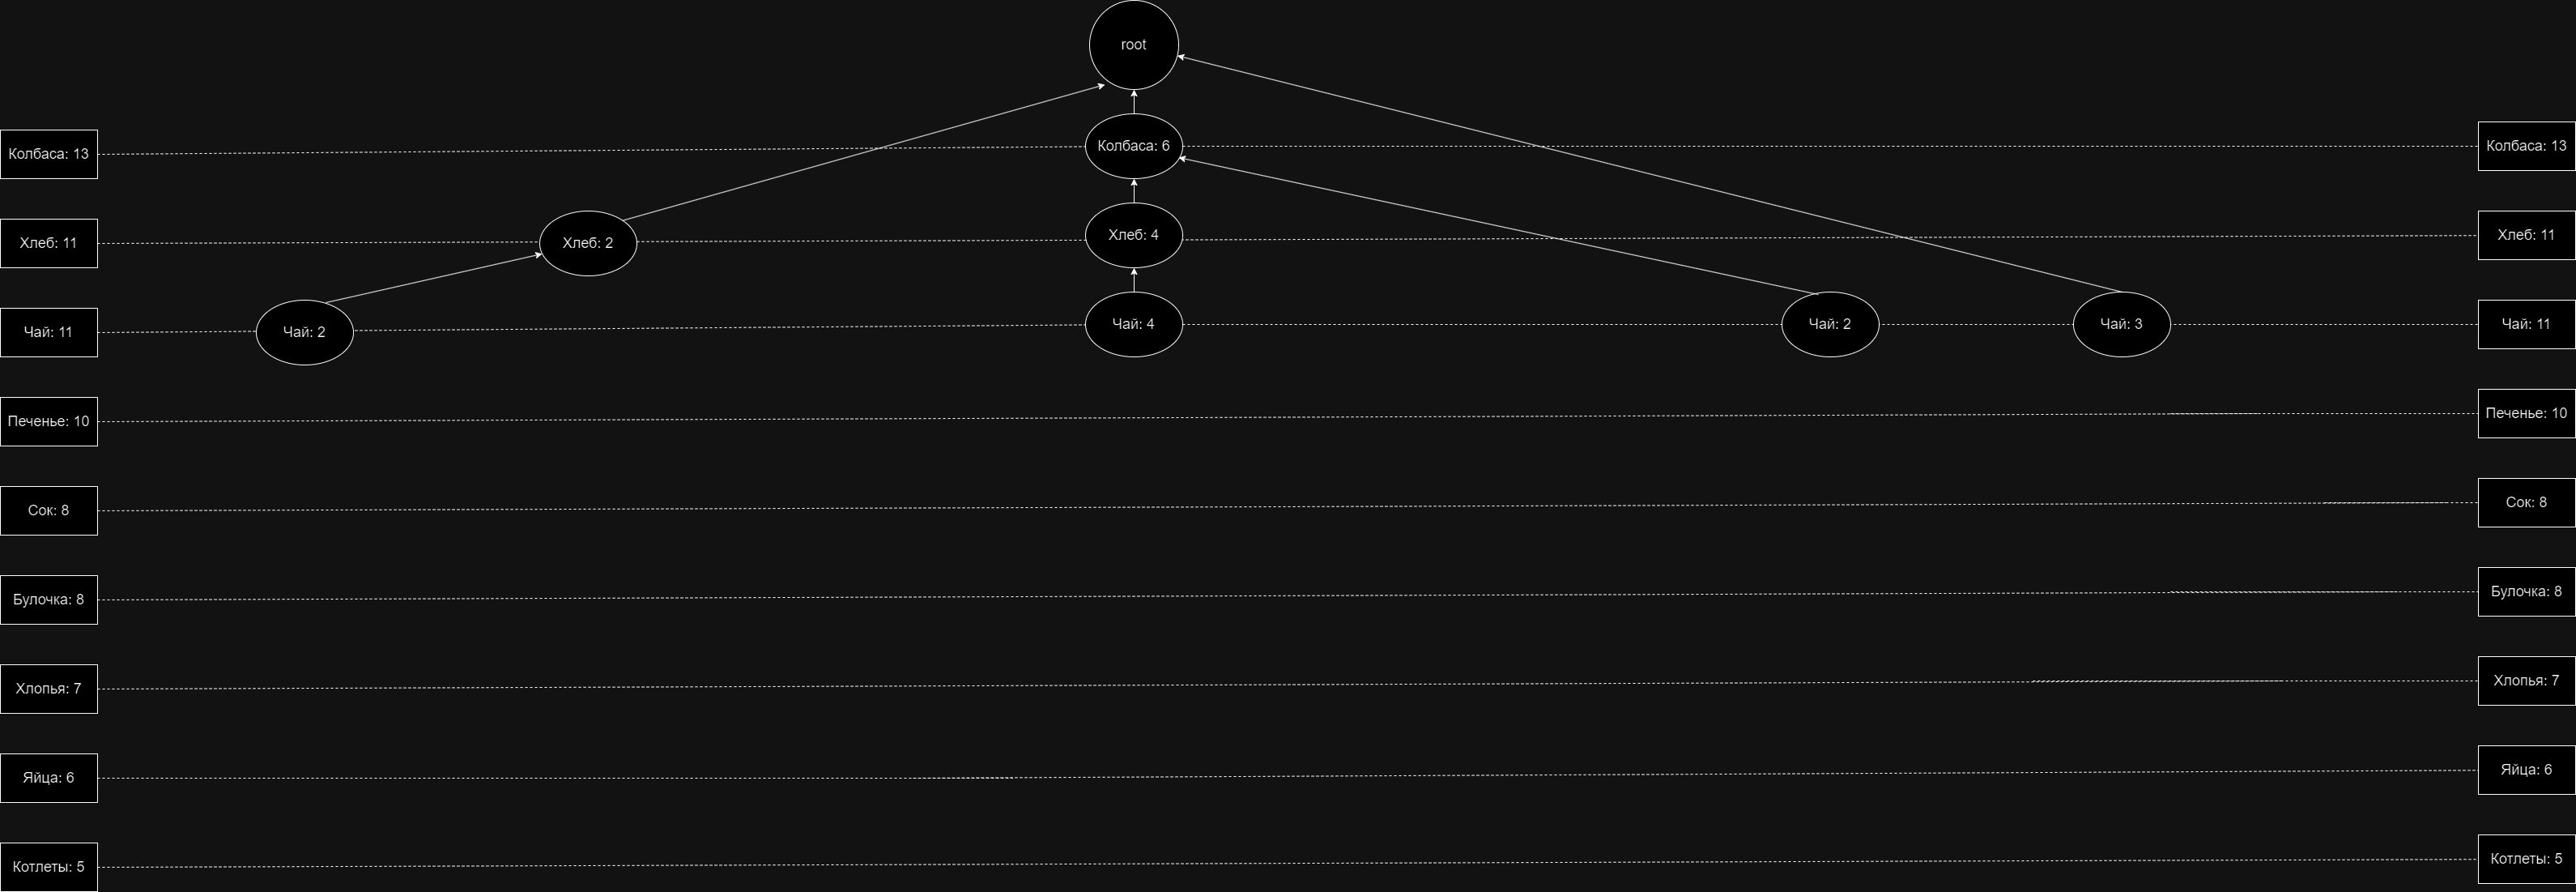

После очистки - осталось две связи, но одиночные, (?) с колбасой и с хлебом
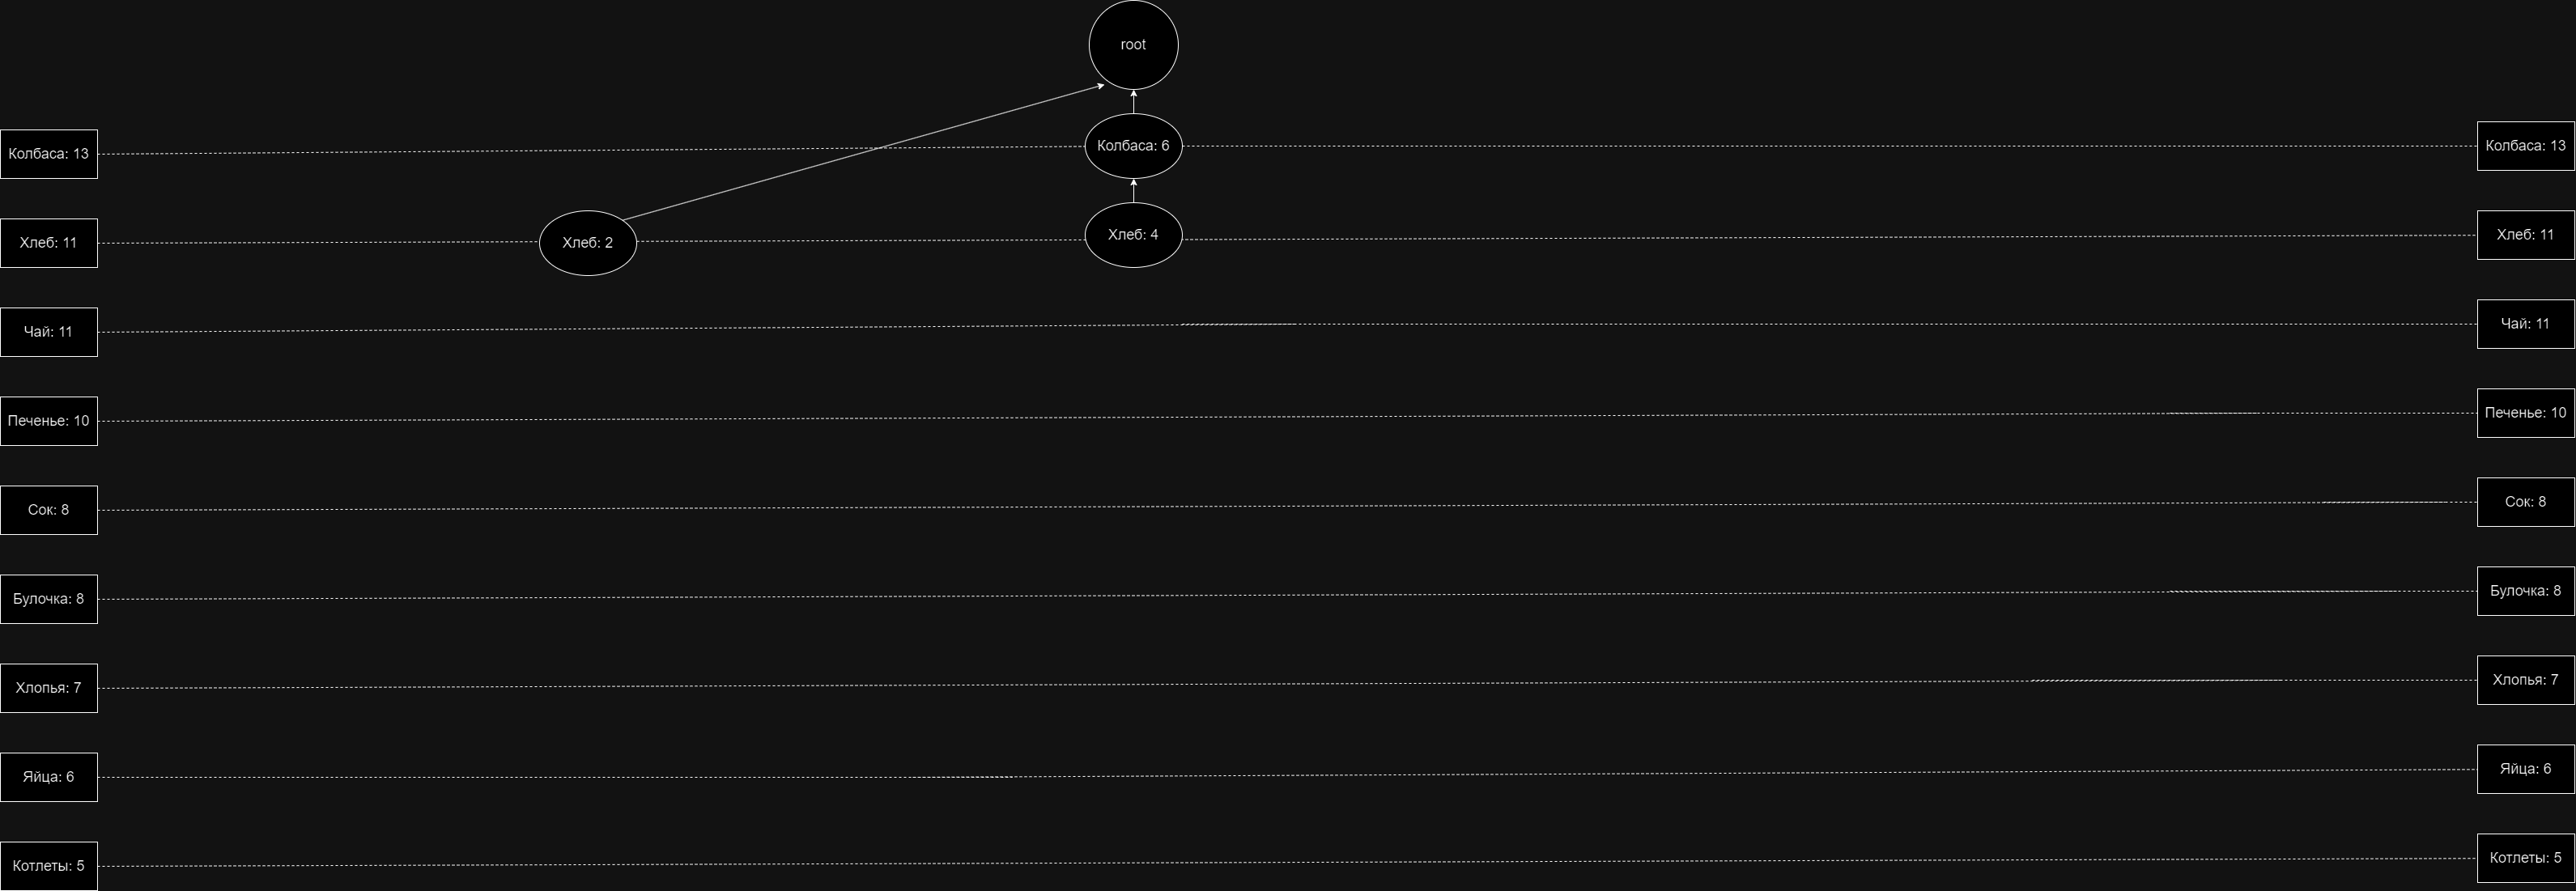

#### Хлеб

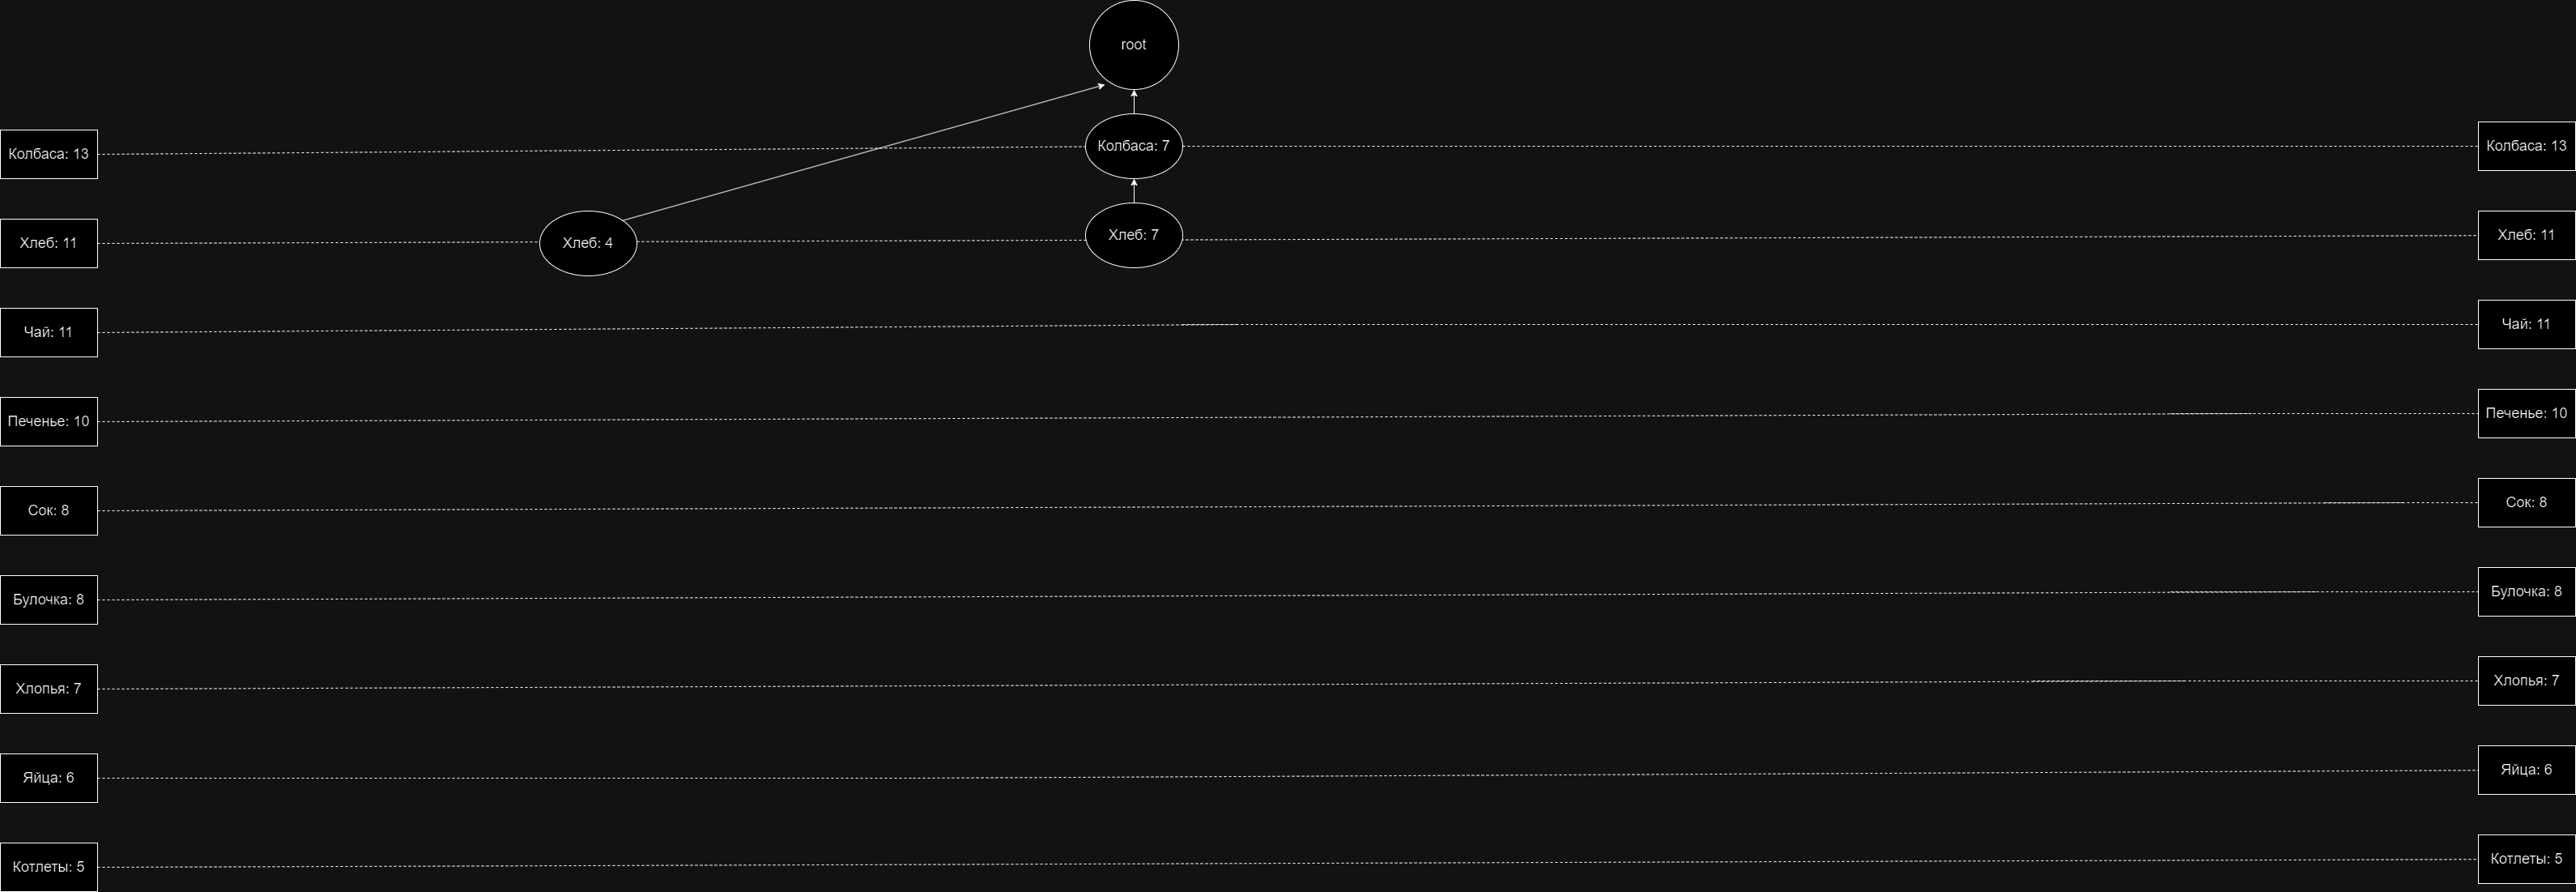

Тут только колбаса и осталась
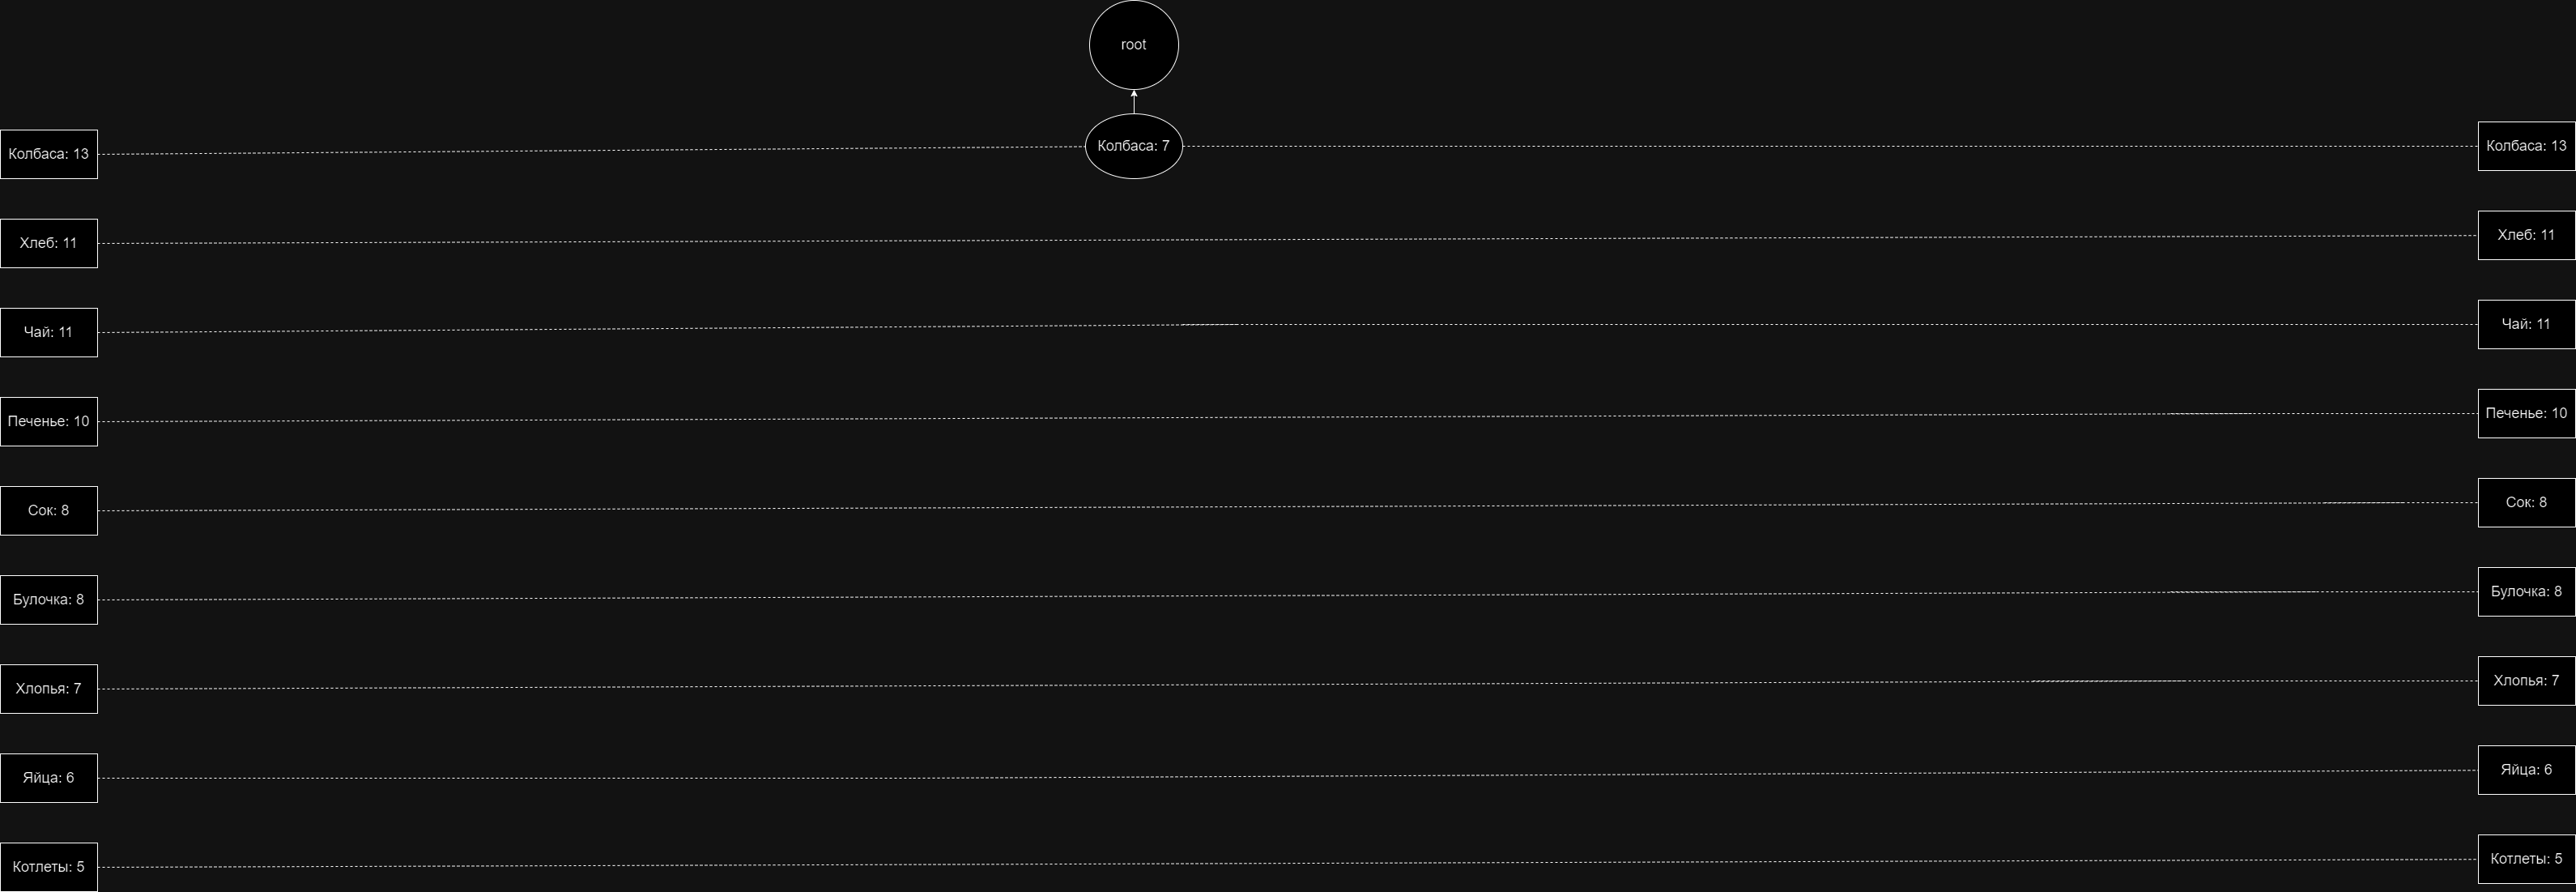

#### Итог

По итогу получились все те же наборы частых товаров, которые обнаружились и в алгоритме apriori. Однако в данном конкретном наборе дерево получилось достаточно "кусообразное" и не слишком оптимальное

### Работа с библиотеками python на собственном наборе данных

Ещё раз отразим наши транзакции

In [5]:
row_data = pd.read_excel("./data/row_data.xlsx", header=None, na_filter=False)
row_data

0        1        2        3        4        5        6    7
0   колбаса   хлопья     хлеб      чай                                
1      яйца     хлеб  булочка  котлеты                                
2       сок  печенье  колбаса                                         
3       чай  сандвич  печенье  булочка                                
4       чай     хлеб  печенье                                         
5   котлеты     яйца  колбаса      чай  булочка                       
6       сок      чай     хлеб  колбаса                                
7   колбаса   хлопья      чай                                         
8       сок      чай                                                  
9   котлеты     яйца  колбаса     хлеб  печенье                       
10     хлеб      чай  сандвич   хлопья                                
11  котлеты  сандвич  печенье      чай     хлеб  булочка  колбаса  сок
12      сок     хлеб  булочка     яйца  колбаса                       
13  печенье  колбаса                                                  
14      сок   хлопья     хлеб  булочка                                
15  колбаса   хлопья  печенье     яйца                                
16  котлеты   хлопья     яйца     хлеб      сок  булочка  колбаса  чай
17      чай  печенье                                                  
18  булочка  печенье  колбаса   хлопья                                
19  сандвич  колбаса  печенье   хлопья      сок     хлеб

Представим их в необходимом для работы библиотек python виде: список списков

In [80]:
data_np = np.array(row_data)
data_np = list(data_np)

data_list = list([])

for l in data_np:
    l = list(np.setdiff1d(l, ""))
    data_list.append(l)

print(data_list)

[['колбаса', 'хлеб', 'хлопья', 'чай'], ['булочка', 'котлеты', 'хлеб', 'яйца'], ['колбаса', 'печенье', 'сок'], ['булочка', 'печенье', 'сандвич', 'чай'], ['печенье', 'хлеб', 'чай'], ['булочка', 'колбаса', 'котлеты', 'чай', 'яйца'], ['колбаса', 'сок', 'хлеб', 'чай'], ['колбаса', 'хлопья', 'чай'], ['сок', 'чай'], ['колбаса', 'котлеты', 'печенье', 'хлеб', 'яйца'], ['сандвич', 'хлеб', 'хлопья', 'чай'], ['булочка', 'колбаса', 'котлеты', 'печенье', 'сандвич', 'сок', 'хлеб', 'чай'], ['булочка', 'колбаса', 'сок', 'хлеб', 'яйца'], ['колбаса', 'печенье'], ['булочка', 'сок', 'хлеб', 'хлопья'], ['колбаса', 'печенье', 'хлопья', 'яйца'], ['булочка', 'колбаса', 'котлеты', 'сок', 'хлеб', 'хлопья', 'чай', 'яйца'], ['печенье', 'чай'], ['булочка', 'колбаса', 'печенье', 'хлопья'], ['колбаса', 'печенье', 'сандвич', 'сок', 'хлеб', 'хлопья']]


И создадим фукнцию для тестирования всех трёх алгоритмов, вместе с подсчётом времени. Для нашего набора данных количество затраченного на алгоритмы времени бессмысленно - оно у всех будет пренебрежительно мало - но оно пригодится при работе с большим набором данных

In [10]:
def make_all_tests(data, minsup=0.5, minconf=0.5):
    # Apriori
    st_apriori = time.time()
    frequent_apriori, rules_apriori = apriori(data, minSup=minsup, minConf=minconf)
    time_apriori = time.time() - st_apriori
    print("Подсчёт apriori выполнен")

    # Efficient apriori
    st_apriori_eff = time.time()
    frequent_eff_apriori, rules_eff_apriori = eff_apriori(data, min_support=minsup, min_confidence=minconf)
    time_apriori_eff = time.time() - st_apriori_eff
    print("Подсчёт efficient_apriori выполнен")

    # FPGrowth
    st_fpg = time.time()
    frequent_fpgrowth, rules_fpgrowth = fpgrowth(data, minSupRatio=minsup, minConf=minconf)
    time_fpg = time.time() - st_fpg
    print("Подсчёт FPGrowth выполнен")

    time_all = [time_apriori, time_apriori_eff, time_fpg]

    return frequent_apriori, rules_apriori, frequent_eff_apriori, rules_eff_apriori, frequent_fpgrowth, rules_fpgrowth, time_all

In [70]:
f_apr, r_apr, f_eapr, r_eapr, f_fp, r_fp, times = make_all_tests(data_list, minsup=0.25, minconf=0.71)

Теперь посмотрим, какие правила алгоритмы нашли и совпали ли они с теми, что были найдены вручную

In [71]:
r_apr

[[{'колбаса', 'хлеб'}, {'сок'}, 0.7142857142857143],
 [{'хлопья'}, {'колбаса'}, 0.75],
 [{'сок'}, {'колбаса'}, 0.75],
 [{'сок'}, {'хлеб'}, 0.75],
 [{'яйца'}, {'колбаса'}, 0.8333333333333334],
 [{'сок', 'хлеб'}, {'колбаса'}, 0.8333333333333334],
 [{'колбаса', 'сок'}, {'хлеб'}, 0.8333333333333334]]

In [72]:
r_eapr

[{сок} -> {колбаса},
 {хлопья} -> {колбаса},
 {яйца} -> {колбаса},
 {сок} -> {хлеб},
 {сок, хлеб} -> {колбаса},
 {колбаса, хлеб} -> {сок},
 {колбаса, сок} -> {хлеб}]

In [73]:
r_fp

[[{'яйца'}, {'колбаса'}, 0.8333333333333334],
 [{'хлопья'}, {'колбаса'}, 0.75],
 [{'сок'}, {'колбаса'}, 0.75],
 [{'сок', 'хлеб'}, {'колбаса'}, 0.8333333333333334],
 [{'колбаса', 'хлеб'}, {'сок'}, 0.7142857142857143],
 [{'колбаса', 'сок'}, {'хлеб'}, 0.8333333333333334],
 [{'сок'}, {'хлеб'}, 0.75]]

Как видно, данные полностью совпали. Значит, всё было посчитано правильно

### Работа со внешними данными

Внимание! Поскольку на сдо не грузятся большие файлы, размером больше 20 МБ, то из архива был удалён файл с данными online_retail.xlsx, который можно загрузить по следующей ссылке (и кинуть в папку data):  
http://archive.ics.uci.edu/dataset/352/online+retail

#### Предобработка

Загрузим данные и посмотрим, как они выглядят

In [4]:
big_data = pd.read_excel("./data/online_retail.xlsx")
big_data.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

В наших данных есть множество пунктов, которые в нашем данном анализе не нужны. Удалим все признаки, кроме двух: InvoiceNo, в качестве номера чека, по которому мы будем группировать данные, и StockCode, в качестве названий товаров, что покупали люди

In [5]:
big_data = big_data.drop(["Description", "Quantity", "InvoiceDate", "UnitPrice", "CustomerID", "Country"], axis=1)

In [6]:
big_data.head(13)

InvoiceNo StockCode
0     536365    85123A
1     536365     71053
2     536365    84406B
3     536365    84029G
4     536365    84029E
5     536365     22752
6     536365     21730
7     536366     22633
8     536366     22632
9     536367     84879
10    536367     22745
11    536367     22748
12    536367     22749

Создадим функцию, которая сгруппирует данные по номеру чека, чтобы их можно было подавать на вход функций для поиска ассоциативных правил

In [7]:
def make_view(data, col_join, col_need):
    """
    Функция для группировки товаров по номеру чека.\n
    data: данные, в которых будет производится группировка\n
    col_join: str, название колонки, по которой нужно будет производить группировку (номер чека)\n
    col_need: str, название колонки, которая будет группироваться (название товара в чеке)\n
    -----
    return: list товаров, в котором каждая строка - товары, что были куплены в одной транзакции 
    """
    id = data[col_join][0]

    N = data.shape[0]
    data_view = []
    trans_1 = list([])

    for i in range(N):
        if(data[col_join][i] != id):
            data_view.append(trans_1)
            trans_1 = list([])
            id = data[col_join][i]
        
        trans_1.append(str(data[col_need][i]))

    data_view.append(trans_1)

    return data_view

In [8]:
data_view = make_view(big_data, "InvoiceNo", "StockCode") 

И посмотрим, как теперь выглядят данные, что будут подаваться на вход

In [9]:
print(f"Всего транзакции в данном наборе данных - {len(data_view)}")

print(data_view[3:6])

Всего транзакции в данном наборе данных - 25901
[['22960', '22913', '22912', '22914'], ['21756'], ['22728', '22727', '22726', '21724', '21883', '10002', '21791', '21035', '22326', '22629', '22659', '22631', '22661', '21731', '22900', '21913', '22540', '22544', '22492', 'POST']]


#### Алгоритмы

И теперь считаем все алгоритмы с помощью ранее написанной фукнции

In [11]:
bd_f_apr, bd_r_apr, bd_f_eapr, bd_r_eapr, bd_f_fp, bd_r_fp, bd_times = make_all_tests(data_view, minsup=0.025, minconf=0.3)

Подсчёт apriori выполнен
Подсчёт efficient_apriori выполнен
Подсчёт FPGrowth выполнен


Сразу посмотрим на время исполнения всех алгоритмов

[284.22649478912354, 0.3889284133911133, 14.597126483917236]


<BarContainer object of 3 artists>

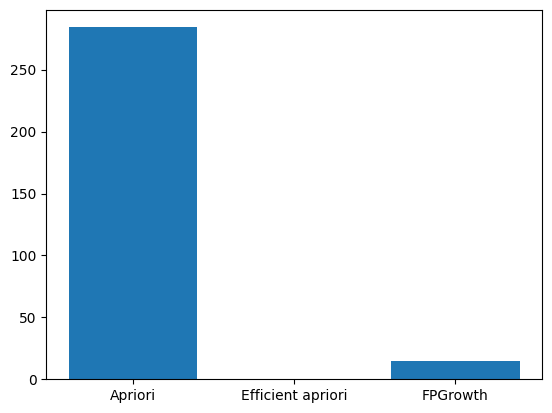

In [31]:
print(bd_times)
plt.bar(["Apriori", "Efficient apriori", "FPGrowth"], bd_times)

Как видно из графика, быстрее всех посчитался алгоритм Efficient apriori - меньше 1 секунды на достаточно большой объём данных, почти 25 тысяч транзакций. Алгоритм FPGrowth считался уже немного медленее, 14.6 секунд  
А вот обычный алгоримт Apriori считался очень долго - больше 4.5 минут, и именно он занял больше 90% времени подсчёта написанной нами функции

Теперь посмотрим на результаты работы алгоритмов

##### Apriori

In [32]:
bd_f_apr

{1: {frozenset({'21929'}),
  frozenset({'23206'}),
  frozenset({'22086'}),
  frozenset({'23199'}),
  frozenset({'22697'}),
  frozenset({'20914'}),
  frozenset({'22865'}),
  frozenset({'85099C'}),
  frozenset({'22630'}),
  frozenset({'21232'}),
  frozenset({'23284'}),
  frozenset({'22960'}),
  frozenset({'20727'}),
  frozenset({'22699'}),
  frozenset({'85099B'}),
  frozenset({'22659'}),
  frozenset({'22423'}),
  frozenset({'23300'}),
  frozenset({'22355'}),
  frozenset({'22907'}),
  frozenset({'22379'}),
  frozenset({'21212'}),
  frozenset({'84946'}),
  frozenset({'22558'}),
  frozenset({'79321'}),
  frozenset({'21928'}),
  frozenset({'22554'}),
  frozenset({'20723'}),
  frozenset({'22382'}),
  frozenset({'84978'}),
  frozenset({'22114'}),
  frozenset({'21166'}),
  frozenset({'22326'}),
  frozenset({'22835'}),
  frozenset({'22910'}),
  frozenset({'85099F'}),
  frozenset({'21930'}),
  frozenset({'22411'}),
  frozenset({'22969'}),
  frozenset({'85123A'}),
  frozenset({'21213'}),
  frozens

In [33]:
bd_r_apr

[[{'85099B'}, {'22411'}, 0.3199063231850117],
 [{'85099B'}, {'21931'}, 0.3433255269320843],
 [{'85099B'}, {'22386'}, 0.3901639344262295],
 [{'20725'}, {'20727'}, 0.40298507462686567],
 [{'20725'}, {'22383'}, 0.4123134328358209],
 [{'20727'}, {'20725'}, 0.5003861003861004],
 [{'22383'}, {'20725'}, 0.5076569678407351],
 [{'22411'}, {'85099B'}, 0.5754001684919966],
 [{'21931'}, {'85099B'}, 0.6103247293921732],
 [{'22386'}, {'85099B'}, 0.6766856214459789],
 [{'22699'}, {'22697'}, 0.7],
 [{'22697'}, {'22699'}, 0.7417218543046358]]

Обычный алгоритм apriori на заданных характеристиках нашёл 12 ассоциативных правил

##### Efficient apriori

In [34]:
bd_f_eapr

{1: {('85123A',): 2246,
  ('84879',): 1468,
  ('21754',): 787,
  ('22960',): 1220,
  ('22728',): 799,
  ('22727',): 1081,
  ('22726',): 1003,
  ('22326',): 749,
  ('22629',): 908,
  ('22659',): 725,
  ('21731',): 861,
  ('POST',): 1254,
  ('22086',): 1170,
  ('82482',): 1118,
  ('82494L',): 931,
  ('22114',): 652,
  ('21733',): 754,
  ('22386',): 1231,
  ('85099C',): 947,
  ('20723',): 734,
  ('20725',): 1608,
  ('21212',): 1334,
  ('21977',): 875,
  ('84991',): 836,
  ('21931',): 1201,
  ('21929',): 877,
  ('22961',): 1174,
  ('22139',): 983,
  ('22411',): 1187,
  ('21166',): 735,
  ('21175',): 817,
  ('22379',): 753,
  ('82484',): 696,
  ('22457',): 1266,
  ('22469',): 1214,
  ('22470',): 944,
  ('22662',): 690,
  ('85099B',): 2135,
  ('79321',): 673,
  ('22969',): 654,
  ('22910',): 832,
  ('22197',): 1442,
  ('21080',): 988,
  ('22865',): 667,
  ('22558',): 783,
  ('85152',): 682,
  ('21232',): 888,
  ('22835',): 663,
  ('22112',): 866,
  ('22111',): 778,
  ('22382',): 1170,
  ('20

In [35]:
bd_r_eapr

[{20727} -> {20725},
 {20725} -> {20727},
 {22383} -> {20725},
 {20725} -> {22383},
 {85099B} -> {21931},
 {21931} -> {85099B},
 {85099B} -> {22386},
 {22386} -> {85099B},
 {85099B} -> {22411},
 {22411} -> {85099B},
 {22699} -> {22697},
 {22697} -> {22699}]

Эффективный apriori нашёл столько же, сколько и обычный - 12 правил. Их результаты совпали, при полном доминировании эффективного над обычным по времени

Так же для efficient apriori есть реализация визуализации правил - PyARMViz. Посмотрим, какие графики она выведет

In [19]:
PyARMViz.metadata_scatter_plot(bd_r_eapr)

##### FPGrowth

In [36]:
bd_f_fp

[{'84992'},
 {'82583'},
 {'22952'},
 {'22969'},
 {'21485'},
 {'21755'},
 {'23321'},
 {'23307'},
 {'22114'},
 {'21915'},
 {'21213'},
 {'22835'},
 {'79321'},
 {'20713'},
 {'85152'},
 {'22865'},
 {'23208'},
 {'22966'},
 {'22551'},
 {'82484'},
 {'84378'},
 {'22385'},
 {'22662'},
 {'84380'},
 {'20685'},
 {'22907'},
 {'DOT'},
 {'21930'},
 {'22554'},
 {'22467'},
 {'23344'},
 {'22624'},
 {'20723'},
 {'21166'},
 {'23284'},
 {'22659'},
 {'22379'},
 {'22326'},
 {'84978'},
 {'21733'},
 {'22356'},
 {'23207'},
 {'23300'},
 {'22558'},
 {'22111'},
 {'21754'},
 {'22728'},
 {'22090'},
 {'23355'},
 {'21928'},
 {'21175'},
 {'22698'},
 {'22698', '22699'},
 {'22697', '22698', '22699'},
 {'22697', '22698', '22699'},
 {'22697', '22698', '22699'},
 {'22697', '22698', '22699'},
 {'22697', '22698', '22699'},
 {'22697', '22698', '22699'},
 {'22697', '22698', '22699'},
 {'22697', '22698', '22699'},
 {'22697', '22698', '22699'},
 {'22697', '22698', '22699'},
 {'22697', '22698', '22699'},
 {'22697', '22698'},
 {'226

In [37]:
bd_r_fp

[[{'22698'}, {'22699'}, 0.7655860349127181],
 [{'22699'}, {'22698'}, 0.5482142857142858],
 [{'22698'}, {'22697', '22699'}, 0.6845386533665836],
 [{'22699'}, {'22697', '22698'}, 0.4901785714285714],
 [{'22697'}, {'22698', '22699'}, 0.5193945127719962],
 [{'22698', '22699'}, {'22697'}, 0.8941368078175895],
 [{'22697', '22698'}, {'22699'}, 0.8524844720496895],
 [{'22697', '22699'}, {'22698'}, 0.7002551020408163],
 [{'22698'}, {'22697', '22699'}, 0.6845386533665836],
 [{'22699'}, {'22697', '22698'}, 0.4901785714285714],
 [{'22697'}, {'22698', '22699'}, 0.5193945127719962],
 [{'22698', '22699'}, {'22697'}, 0.8941368078175895],
 [{'22697', '22698'}, {'22699'}, 0.8524844720496895],
 [{'22697', '22699'}, {'22698'}, 0.7002551020408163],
 [{'22698'}, {'22697', '22699'}, 0.6845386533665836],
 [{'22699'}, {'22697', '22698'}, 0.4901785714285714],
 [{'22697'}, {'22698', '22699'}, 0.5193945127719962],
 [{'22698', '22699'}, {'22697'}, 0.8941368078175895],
 [{'22697', '22698'}, {'22699'}, 0.85248447204

А вот с алгоритмов FPGrowth вышла странность. Он нашёл, помимо двоек ассоциативных правил, ещё и тройки при тех же настройках гиперпараметров, так ещё и в результате продублировал некоторые правила, расклонировав их...

### Вывод

Таким образом, мы познакомились с алгоритмами Apriori и FPGrowth, проработали их вручную на собственном искусственном небольшом наборе данных, а так же посмотрели и проанализировали результаты работы библиотек для python, реализовывающих алгоритмы apriori, efficient apriori и fpgrowth.